# Dataset info for MIMIC experiments

In [5]:
from pathlib import Path
import pandas as pd

PATHS = [
    "/workspaces/defrag/paper_experiments/mimic_experiment_breast_soft_hierarchical_5",
    "/workspaces/defrag/paper_experiments/mimic_experiment_lung_soft_hierarchical_5",
    "/workspaces/defrag/paper_experiments/mimic_experiment_melanoma_soft_hierarchical_5",
]

data = []
for path in PATHS:
    if "breast" in path:
        experiment = "breast"
    elif "lung" in path:
        experiment = "lung"
    elif "melanoma" in path:
        experiment = "melanoma"
    else:
        raise ValueError()
    df = pd.read_parquet(next(Path(path).rglob("filtered_mimic_features.parquet")))

    events = len(df)
    patients = len(df.patient_id.unique())
    hadms = len(df.hadm_id.unique())
    codes = len(df.p_icd9_code.unique())
    data.append({
        "Experiment": experiment,
        "Events": events,
        "Patients": patients,
        "Admissions": hadms,
        "ICD codes": codes,
    })

print(pd.DataFrame(data).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Experiment &  Events &  Patients &  Admissions &  ICD codes \\
\midrule
    breast &   14178 &      1576 &        3926 &       1139 \\
      lung &   10132 &       958 &        2483 &        787 \\
  melanoma &    4019 &       482 &        1221 &        689 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3221595/844547716.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


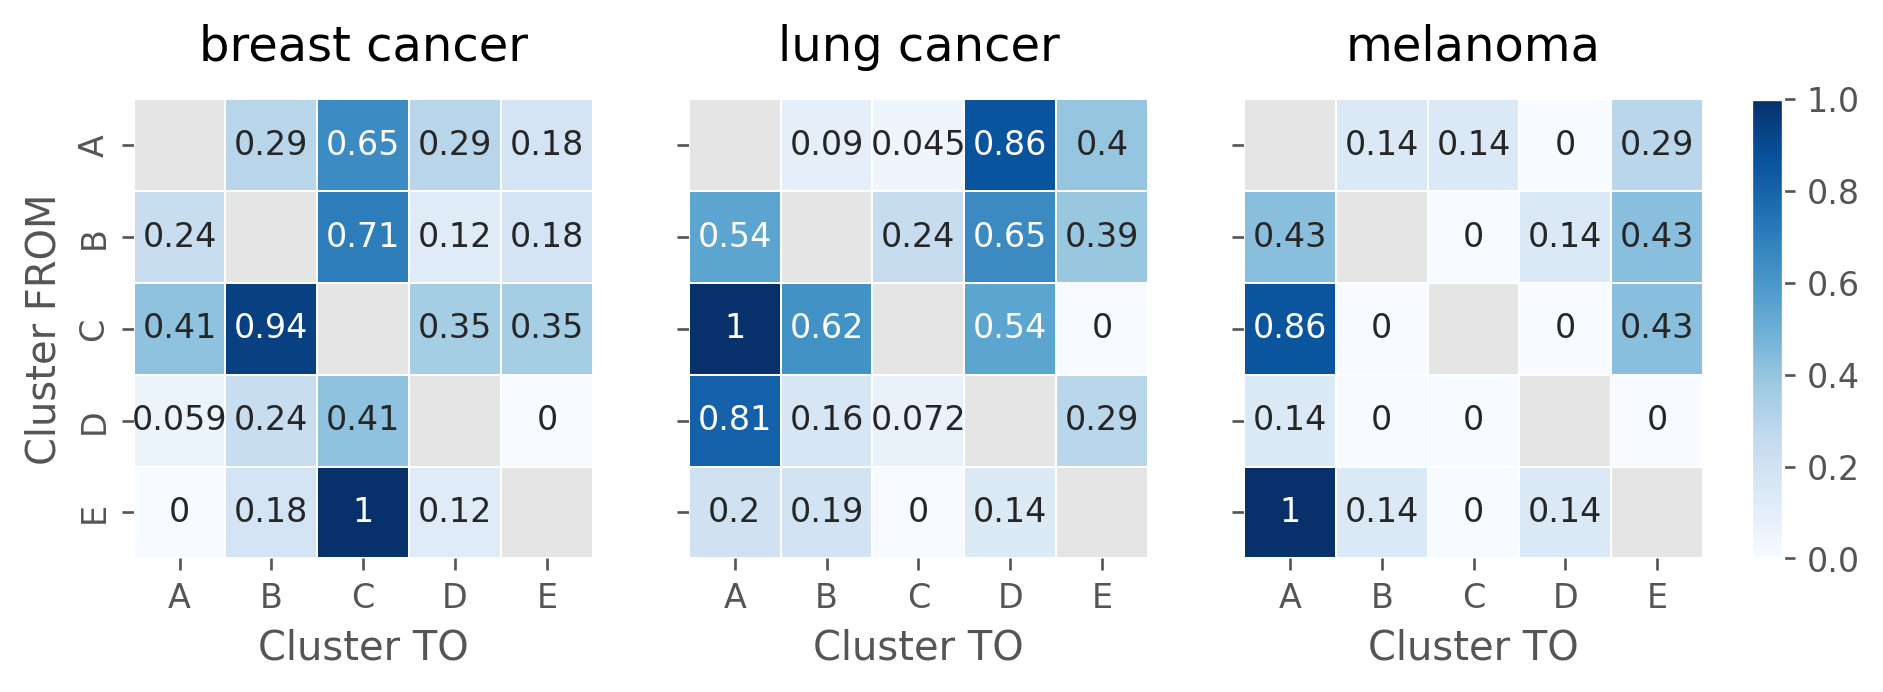

In [24]:
# https://stackoverflow.com/a/38940369

from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
import seaborn as sns

from defrag import Defrag
from _constants import DEFRAG_DATA

PATHS = [
    "/workspaces/defrag/paper_experiments/mimic_experiment_breast_soft_hierarchical_5",
    "/workspaces/defrag/paper_experiments/mimic_experiment_lung_soft_hierarchical_5",
    "/workspaces/defrag/paper_experiments/mimic_experiment_melanoma_soft_hierarchical_5",
]

def plot_am(am: np.array, tick_labels: List[str], title, axis: plt.Axes):
    mean, std = np.nanmean(am), np.nanstd(am)

    axis = sns.heatmap(am, square=True, cmap="Blues", linewidths=0.1, ax=axis, annot=True, cbar=False)
    axis.set_title(
        title
        #   + f"\nmean={mean:.2f}, std={std:.2f}"
        , y=1.04)
    axis.set_xticks(ticks=np.array(range(len(tick_labels))) + 0.5, labels=tick_labels)
    axis.set_yticks(ticks=np.array(range(len(tick_labels))) + 0.5, labels=tick_labels)
    axis.set_xlabel("Cluster TO")
    axis.set_ylabel("Cluster FROM")
    return axis

# fig, axs = plt.subplots(1, 4, figsize=(10, 3), dpi=240)
# Set up figure and image grid
fig = plt.figure(figsize=(12, 3), dpi=240)

grid = ImageGrid(
    fig,                  
    111,          # as in plt.subplot(111)                 
    nrows_ncols=(1,3),                 
    axes_pad=0.4,                 
    share_all=True,                 
    cbar_location="right",                 
    cbar_mode="single",                 
    cbar_size="7%",                 
    cbar_pad=0.2,
)
for experiment, ax, title in zip(PATHS, grid, ["breast cancer", "lung cancer", "melanoma"]):
    defrag_data = next(Path(experiment).rglob(DEFRAG_DATA))
    archive = np.load(defrag_data)
    ram, sam, ham = archive["ram"], archive["sam"], archive["ham"]
    # Set the diagonal of ram to zero
    bidirectional_ram = ram.copy().astype(np.float32).T
    np.fill_diagonal(bidirectional_ram, np.nan)
    bidirectional_ram = bidirectional_ram / np.nanmax(bidirectional_ram)
    bidirectional_nxG = Defrag.am_to_nxG(bidirectional_ram)
    axis = plot_am(bidirectional_ram, list(bidirectional_nxG.nodes()), title, ax)
    # Defrag.plot_adjacency_matrix(bidirectional_ram, list(bidirectional_nxG.nodes()))

# Colorbar
ax.cax.colorbar(axis.collections[0])
ax.cax.toggle_label(True)
fig.tight_layout()
plt.savefig("paper_figures/mimic_soft_adjacency_matrices.pdf", bbox_inches="tight")
plt.show()

# scp achomevpn:defrag/mimic_soft_adjacency_matrices.pdf figures/mimic_soft_adjacency_matrices.pdf


# Synthetic Data Experiment Plots

[5 7 9 3]


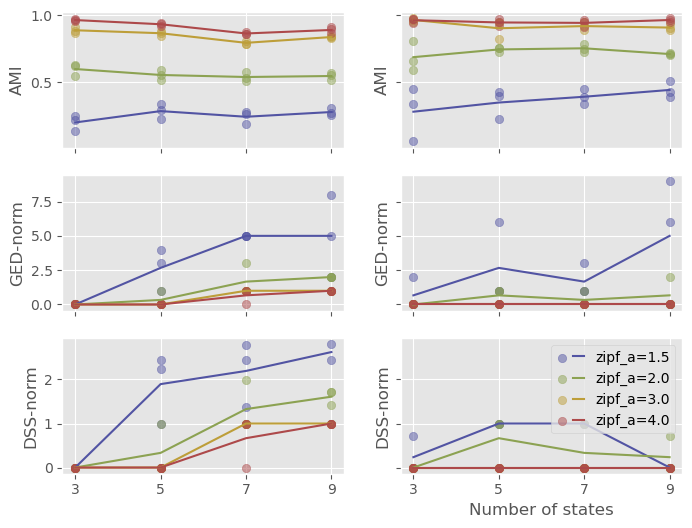

In [27]:
from pathlib import Path
import yaml
import shutil

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple

from plot import cmap40, thesis_figure_formatting, thesis_figure_save
from _constants import DEFRAG_RESULTS, CLUSTERS_STATS

experiment_path = "/workspaces/defrag/experiments/synthetic_data_experiment_big"#_1000_bins"
experiment_path = Path(experiment_path)

# Iterate over all the experiments in the experiment path
# Only iterate over directories
df = []
for experiment in experiment_path.iterdir():
    if not experiment.is_dir():
        continue
    catsyn_config = yaml.load(open(next(experiment.glob("catsyn_config*.yml"))), Loader=yaml.FullLoader)
    run_params = {
        "experiment_name": str(experiment.stem),
        "patients": catsyn_config["patients"],
        "seed": catsyn_config["seed"],
        "zipf_a": catsyn_config["variable_generator"]["variable_kwargs"]["distribution_kwargs"]["a"],
        "states": catsyn_config["states_generator"]["nb_states"],
        "variables": catsyn_config["variable_generator"]["nb_variables"],
        "bins": catsyn_config["variable_generator"]["variable_kwargs"]["n_bins"],
    }

    # if run_params["states"] not in [3, 5, 7, 9]:
    #     # shutil.rmtree(experiment)
    #     print("WOULD DELETE", experiment)
    #     continue
    # if not (experiment / CLUSTERS_STATS).exists():
    #     print("WOULD SKIP", run_params)
    #     continue
    clustering_results = yaml.load(open(experiment / CLUSTERS_STATS), Loader=yaml.FullLoader)
    cluster_stats = {
        "ami": clustering_results["ami"],
    }
    # if not (experiment / DEFRAG_RESULTS).exists():
    #     print("WOULD SKIP", run_params)
    #     continue
    defrag_results = yaml.load(open(experiment / DEFRAG_RESULTS), Loader=yaml.FullLoader)
    # if run_params["states"] == 9 and run_params["variables"] == 2 and run_params["bins"] == 100 and run_params["zipf_a"] == 1.5:
    #     print(run_params, experiment)
    df.append({
        **run_params,
        **cluster_stats,
        **defrag_results,
    })

df = pd.DataFrame(df)
print(df.states.unique())
df["AMI"] = df.ami
df["GED-norm"] = df.edit_distance# / df.states
df["DSS-norm"] = df.degree_distance# / df.states

thesis_figure_formatting()
fig, axs = plt.subplots(3, 2, sharex=True, sharey='row', figsize=(8, 6))
vars = df.variables.sort_values(ascending=True).unique().tolist()
yaxs = ["AMI", "GED-norm", "DSS-norm"]
for var, col in zip(vars, [axs[:, 0], axs[:, 1]]):
    for ax, y_col in zip(col, yaxs):
        Xs = df.states.sort_values(ascending=True).unique().tolist()
        seeds = df.seed.sort_values(ascending=True).unique().tolist()
        zipfas = df.zipf_a.sort_values(ascending=True).unique().tolist()
        colours = iter(cmap12)
        legend_handles = {}
        for zipfa in zipfas:
            # Plot the scatter points for each run (different seed)
            legend_label = f"zipf_a={zipfa}"
            handles = []
            colour = next(colours)
            Xs_ = []
            Ys_ = []
            for seed in seeds:
                df_ = df[(df.seed == seed) & (df.zipf_a == zipfa) & (df.variables == var)]
                df_ = df_.sort_values(by="states", ascending=True)
                Xs_ += df_.states.tolist()
                Ys_ += df_[y_col].tolist()
            handle = ax.scatter(Xs_, Ys_, color=colour, alpha=0.5)
            handles.append(handle)
            # Average out the runs for each seed and plot a line
            df_ = df[(df.zipf_a == zipfa) & (df.variables == var)]
            df_ = df_[[y_col, "states"]].groupby(["states"]).mean().reset_index()
            df_ = df_.sort_values(by="states", ascending=True)
            handle = ax.plot(df_.states, df_[y_col], color=colour, alpha=1)
            handles.append(handle[0])

            legend_handles[legend_label] = tuple(handles)

        # Set x ticks to be the number of states
        ax.set_xticks(Xs)
        # ax.set_ylim(-0.05, max(1, df[y_col].max()))
        ax.set_ylabel(y_col)

plt.xlabel("Number of states")
plt.legend(list(legend_handles.values()), list(legend_handles.keys()), handler_map={tuple: HandlerTuple(ndivide=None)})
plt.show()


In [6]:
from pathlib import Path
import yaml
import shutil

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns

from plot import cmap40, thesis_figure_formatting, thesis_figure_save
from _constants import DEFRAG_RESULTS, CLUSTERS_STATS

def get_experiment_results(experiment_path: Path) -> pd.DataFrame:
    # Iterate over all the experiments in the experiment path
    # Only iterate over directories
    df = []
    for experiment in experiment_path.iterdir():
        if not experiment.is_dir():
            continue
        catsyn_config = yaml.load(open(next(experiment.glob("catsyn_config*.yml"))), Loader=yaml.FullLoader)
        run_params = {
            "experiment_name": str(experiment.stem),
            "patients": catsyn_config["patients"],
            "seed": catsyn_config["seed"],
            "zipf_a": catsyn_config["variable_generator"]["variable_kwargs"]["distribution_kwargs"]["a"],
            "states": catsyn_config["states_generator"]["nb_states"],
            "variables": catsyn_config["variable_generator"]["nb_variables"],
            "bins": catsyn_config["variable_generator"]["variable_kwargs"]["n_bins"],
        }
        clustering_results = yaml.load(open(experiment / CLUSTERS_STATS), Loader=yaml.FullLoader)
        cluster_stats = {
            "ami": clustering_results["ami"],
        }
        defrag_results = yaml.load(open(experiment / DEFRAG_RESULTS), Loader=yaml.FullLoader)
        df.append({
            **run_params,
            **cluster_stats,
            **defrag_results,
        })
    return pd.DataFrame(df)

def plot_results(df: pd.DataFrame, save_path: str = None):
    df["AMI"] = df.ami
    df["GED"] = df.edit_distance# / df.states
    df["DSS"] = df.degree_distance# / df.states

    thesis_figure_formatting()
    fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(6, 4))
    vars = df.variables.sort_values(ascending=True).unique().tolist()
    yaxs = ["AMI", "GED"]#, "DSS"]
    for var, col in zip(vars, [axs[:, 0], axs[:, 1]]):
        for ax, y_col in zip(col, yaxs):
            Xs = df.states.sort_values(ascending=True).unique().tolist()
            zipfas = df.zipf_a.sort_values(ascending=True).unique().tolist()
            colours = iter(cmap40)

            for zipfa in zipfas:
                df_ = df[(df.zipf_a == zipfa) & (df.variables == var)]
                colour = next(colours)
                legend_label = f"zipf_a={zipfa}"
                sns.regplot(
                    data=df_, 
                    x="states", 
                    y=y_col, 
                    color=colour, 
                    ax=ax, 
                    scatter=True, 
                    order=1, 
                    label=legend_label,
                    scatter_kws={"s": 10, "alpha": 0.5}
                )
            ax.set_xticks(Xs)
            ax.set_xlim(min(Xs), max(Xs))
            ax.set_ylabel(y_col)
            if y_col == yaxs[-1]:
                ax.set_xlabel("Num. vertices")
            else:
                ax.set_xlabel("")

    axs[0, 0].set_title("1 variable")
    axs[0, 1].set_title("2 variables")
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()



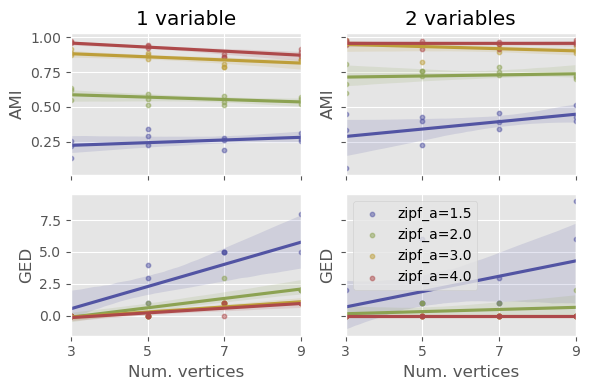

In [7]:
experiment_path = "/workspaces/defrag/experiments/synthetic_data_experiment_big"
experiment_path = Path(experiment_path)
bins100df = get_experiment_results(experiment_path)
plot_results(bins100df, "paper_figures/synthetic_data_experiment_big.pdf")

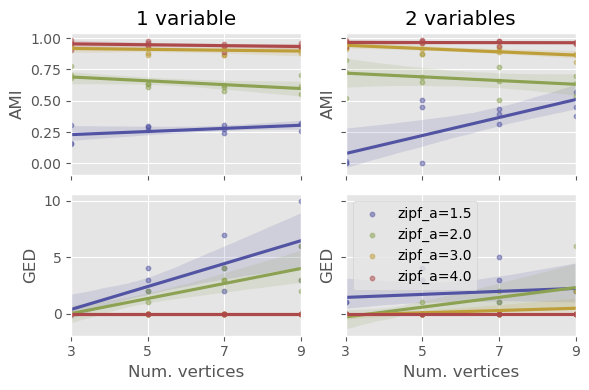

In [8]:
experiment_path = "/workspaces/defrag/experiments/synthetic_data_experiment_big_1000_bins"
experiment_path = Path(experiment_path)
bins1000df = get_experiment_results(experiment_path)
plot_results(bins1000df, "paper_figures/synthetic_data_experiment_big_1000_bins.pdf")

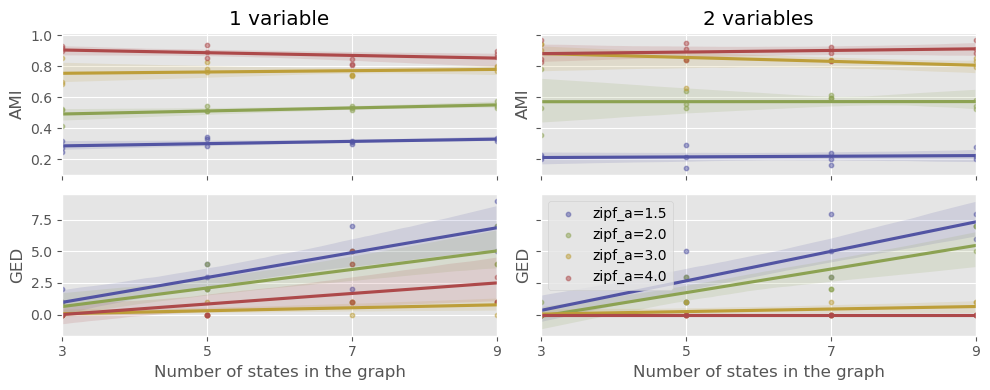

In [27]:
experiment_path = "/workspaces/defrag/experiments/synthetic_data_experiment_big_hierarchical"
experiment_path = Path(experiment_path)
bins100df = get_experiment_results(experiment_path)
plot_results(bins100df, "paper_figures/synthetic_data_experiment_big.pdf")

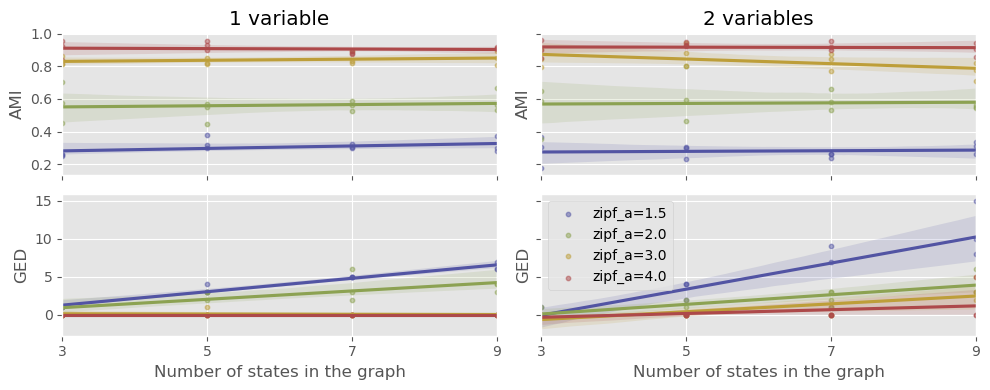

In [28]:
experiment_path = "/workspaces/defrag/experiments/synthetic_data_experiment_big_1000_bins_hierarchical"
experiment_path = Path(experiment_path)
bins1000df = get_experiment_results(experiment_path)
plot_results(bins1000df, "paper_figures/synthetic_data_experiment_big_1000_bins.pdf")

In [28]:
df

experiment_name  patients  seed  zipf_a  states  variables  bins  \
0   experiment_089efd7      1000     1     4.0       5          2   100   
1   experiment_8759cc3      1000     1     4.0       7          1   100   
2   experiment_64bf680      1000     2     3.0       7          2   100   
3   experiment_edef13a      1000     1     4.0       9          1   100   
4   experiment_ce46c16      1000     3     3.0       7          2   100   
..                 ...       ...   ...     ...     ...        ...   ...   
91  experiment_31666e8      1000     2     3.0       5          1   100   
92  experiment_27c43e7      1000     1     4.0       7          2   100   
93  experiment_4256e81      1000     1     3.0       7          1   100   
94  experiment_7dfc798      1000     1     2.0       7          1   100   
95  experiment_4177b19      1000     3     2.0       5          1   100   

         ami  approx_ged  degree_distance  edit_distance  inf_contains_syn  \
0   0.918790       False              0.0              0              True   
1   0.860798       False              1.0              1             False   
2   0.892083       False              0.0              0              True   
3   0.895954       False              1.0              1             False   
4   0.948147       False              0.0              0              True   
..       ...         ...              ...            ...               ...   
91  0.885241       False              0.0              0              True   
92  0.915206       False              0.0              0              True   
93  0.808909       False              1.0              1             False   
94  0.577847       False              1.0              1             False   
95  0.558768       False              1.0              1             False   

    is_isomorphic syn_contains_inf       AMI  GED-norm  DSS-norm  
0            True             True  0.918790         0       0.0  
1           False            False  0.860798         1       1.0  
2            True             True  0.892083         0       0.0  
3           False            False  0.895954         1       1.0  
4            True             True  0.948147         0       0.0  
..            ...              ...       ...       ...       ...  
91           True             True  0.885241         0       0.0  
92           True             True  0.915206         0       0.0  
93          False            False  0.808909         1       1.0  
94          False            False  0.577847         1       1.0  
95          False            False  0.558768         1       1.0  

[96 rows x 17 columns]

In [45]:
df[pd.isna(df["degree_distance"])]

import networkx as nx

from defrag import Eval
from _constants import DEFRAG_DATA, DEFRAG_RESULTS


def score_inferred_graph(exp_path):
    defrag_data_path = exp_path / DEFRAG_DATA
    defrag_results_path = exp_path / DEFRAG_RESULTS
    defrag_data = np.load(defrag_data_path)
    ham = defrag_data["ham"]
    syn_am = np.load(exp_path / "syn_G_adjacency_matrix.npz")['am']
    syn_G_nx = nx.from_numpy_matrix(syn_am.T, create_using=nx.DiGraph)
    inf_G_nx = nx.from_numpy_matrix(ham, create_using=nx.DiGraph)
    # with open(defrag_results_path, "w") as f:
    #     yaml.dump(defrag_results, f)
    deg_dist = None
    print(len(syn_G_nx), len(inf_G_nx))
    if len(syn_G_nx) == len(inf_G_nx):
        # Get the in and out degree sequence of the directed synthetic graph
        syn_in_deg_seq = sorted([d for n, d in syn_G_nx.in_degree()])
        syn_out_deg_seq = sorted([d for n, d in syn_G_nx.out_degree()])
        # Get the in and out degree sequence of the directed inferred graph
        inf_in_deg_seq = sorted([d for n, d in inf_G_nx.in_degree()])
        inf_out_deg_seq = sorted([d for n, d in inf_G_nx.out_degree()])
        # Calculate the euclidean distance between the degree sequences
        in_deg_dist = np.linalg.norm(np.array(syn_in_deg_seq) - np.array(inf_in_deg_seq))
        out_deg_dist = np.linalg.norm(np.array(syn_out_deg_seq) - np.array(inf_out_deg_seq))
        # Calculate the average degree sequence distance
        deg_dist = float((in_deg_dist + out_deg_dist) / 2)
    print(deg_dist)

score_inferred_graph(experiment_path / "experiment_541a23c")


5 6
None


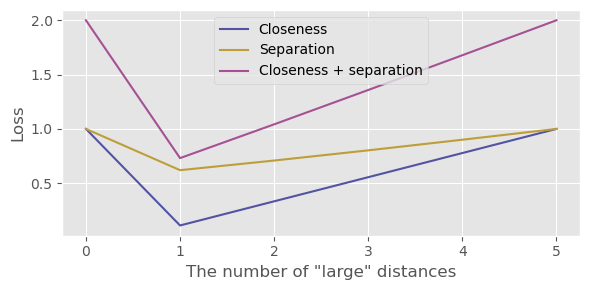

In [44]:
# Loss function
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from plot import thesis_figure_formatting, thesis_figure_save, cmap40

thesis_figure_formatting()

zeta = 10
eta = 20

def loss(distances):
    distances_sorted = sorted(distances)
    d_max = distances_sorted[-1]
    d_mean = np.mean(distances_sorted[:-1])
    closeness = d_mean / (min(d_max, zeta))
    separation = 1 - np.tanh((d_max - d_mean) / eta)
    return closeness, separation, sum([closeness, separation])

# Plot each component and the sum the loss function components
distances = [
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 9],
    [1, 1, 1, 9, 9],
    [1, 1, 9, 9, 9],
    [1, 9, 9, 9, 9],
    [9, 9, 9, 9, 9],
]

colours = iter(cmap40[::2])

Xs = np.arange(len(distances))
closeness = []
separation = []
losses = []
for distance in distances:
    closeness_, separation_, loss_ = loss(distance)
    closeness.append(closeness_)
    separation.append(separation_)
    losses.append(loss_)

plt.figure(figsize=(6, 3))
plt.plot(Xs, closeness, label="Closeness", color=next(colours))
plt.plot(Xs, separation, label="Separation", color=next(colours))
plt.plot(Xs, losses, label="Closeness + separation", color=next(colours))
plt.xlabel("The number of \"large\" distances")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("paper_figures/loss_function.pdf")
plt.show()


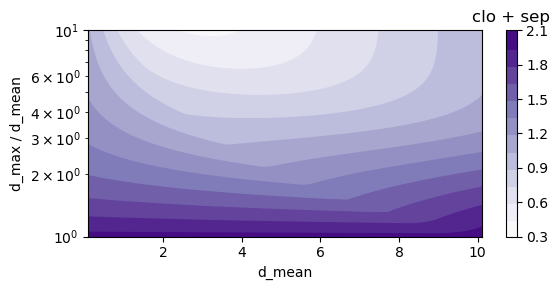

In [6]:
# Loss function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

from plot import thesis_figure_formatting, thesis_figure_save, cmap40

# thesis_figure_formatting()

@np.vectorize
def loss(d_mean, d_max, mode = "sum"):
    d_max = d_mean * d_max
    # closeness = d_mean / np.min([d_max, zeta])
    closeness = d_mean / np.clip(d_max, a_min=1e-8, a_max=zeta)
    separation = 1 - np.tanh((d_max - d_mean) / eta)
    if d_max < d_mean:
        return np.nan
    if mode == "sum":
        return np.sum([closeness, separation])
    if mode == "closeness":
        return closeness
    if mode == "separation":
        return separation


zeta = 10
eta = 20

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
delta = 0.1
D_MEAN = np.arange(delta, 10 + 2 * delta, delta)
D_MAX = np.arange(10, 1 - delta, -1 * delta)
X, Y = np.meshgrid(D_MEAN, D_MAX)
Z = loss(X, Y, mode="sum")
# Z = loss(X, Y, mode="sum")

plt.figure(figsize=(6, 3))

# from scipy.ndimage import gaussian_filter
# Z = gaussian_filter(Z, sigma=10)

# plt.imshow(Z, cmap="Greens")
cs = plt.contourf(
    X, Y, Z, 
    # hatches =['-', '/','\\', '//'],
    levels=10,
    # cmap='viridis',
    cmap="Purples",
    # extend ='both',
    alpha = 1,
    linestyles="solid"
)
for a in cs.collections:
    a.set_edgecolor('face')

# Set x ticks and axis titles
# plt.xticks(np.arange(0, len(D_MEAN) + 1, 250), np.round(D_MEAN[::250]*10)/10)
# plt.yticks(np.arange(0, len(D_MAX) + 1, 250), np.round(D_MAX[::250]*10)/10)  # For imshow
# plt.yticks(list(range(len(D_MAX[::250]))), np.round(D_MAX[::250]*10)/10)  # For contourf
plt.xlabel("d_mean")
plt.ylabel("d_max / d_mean")

# For each Y, find the X value of the minimum Z value.
# Then, plot the (X, Y) contour of the minimum Z value.
# minima = []
# colours = []
# for y in range(len(D_MAX)):
#     minima.append(X[y, np.argmin(Z[y, :])])
#     colours.append(Z[y, np.argmin(Z[y, :])])
# colours = (np.array(colours) - np.min(colours)) / (np.max(colours) - np.min(colours))
# plt.plot(minima, D_MAX, color="black", linestyle="dashed", label="Minimum loss")


# Add a color bar which maps values to colors.
clb = plt.colorbar()
for a in clb.ax.collections:
    a.set_edgecolor('face')

clb.ax.set_title('clo + sep')

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(Z.min(), Z.max())
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

plt.semilogy()
# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.savefig("paper_figures/clo_sep_grid.pdf")
plt.show()


AMI: 0.7892900210680529
AMI: 0.8159899289765914


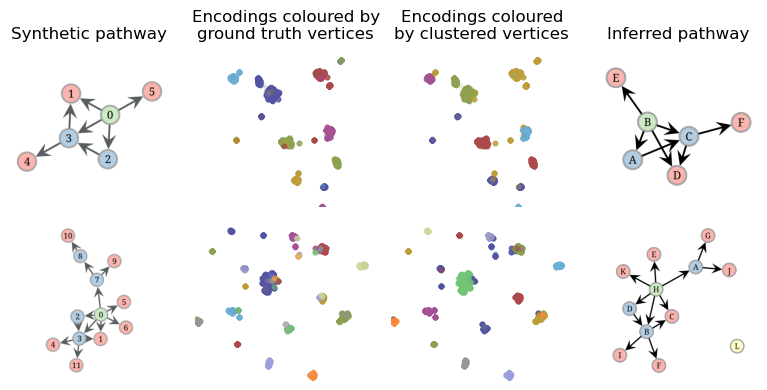

In [14]:
%matplotlib inline
from pathlib import Path

import yaml
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from plot import thesis_figure_formatting
from gallery import view_results
from image_processor import img_from_path, _plot_encodings, hide
from _constants import GTG_PLOT_ALPHA, GTG_SOFT_PLOT_ALPHA


experiment_names = ["experiment_04bb0f4", "experiment_d577d9d"]



fig, axs = plt.subplots(2, 4, figsize=(8, 4))
# thesis_figure_formatting()

for ax_row, experiment_name in zip(axs, experiment_names):
    demo_experiment = Path("/workspaces/defrag/experiments/synthetic_data_experiment_30k_hierarchical_single_var") / experiment_name
    raw_data_path = demo_experiment / "final_representations.npz"
    raw_data = np.load(raw_data_path, allow_pickle=True)
    raw_data = {k: v for k, v in raw_data.items()}
    raw_data["pw_seq_embeddings"] = raw_data["pw_seq_embeddings"].item()
    cluster_labels = pd.read_csv(demo_experiment / "clustered_events.csv")

    # Read the cluster stats yaml file and print the AMI
    print(f"AMI: {yaml.load(open(demo_experiment / 'clustered_stats.yaml'), Loader=yaml.FullLoader)['ami']}")

    ax_row[0].imshow(img_from_path(demo_experiment / "graph.png"))
    _plot_encodings(
        umap_embeddings=raw_data["embeddings"],
        dataset_targets=cluster_labels["y"],
        ax=ax_row[1],
        alpha=0.1,
        s=10,
    )
    _plot_encodings(
        umap_embeddings=raw_data["embeddings"],
        dataset_targets=cluster_labels["y_hat"],
        ax=ax_row[2],
        alpha=0.1,
        s=10,
    )
    gtg_path = demo_experiment / GTG_PLOT_ALPHA
    # if (demo_experiment / GTG_SOFT_PLOT_ALPHA).exists():
    #     print("Using soft GTG plot")
    #     gtg_path = demo_experiment / GTG_SOFT_PLOT_ALPHA

    ax_row[3].imshow(img_from_path(gtg_path))


    for ax in ax_row:
        hide(ax)
# plot_gtg_on_axis(demo_experiment, axs[0])
# plot_gtg_on_axis(demo_experiment, axs[1])
# plot_gtg_on_axis(demo_experiment, axs[2])
# plot_gtg_on_axis(demo_experiment, axs[3])

axs[0][0].set_title("Synthetic pathway")
axs[0][1].set_title("Encodings coloured by\nground truth vertices")
axs[0][2].set_title("Encodings coloured\nby clustered vertices")
axs[0][3].set_title("Inferred pathway")

plt.tight_layout()
plt.savefig("paper_figures/demo_experiments.pdf", dpi=300)
plt.show()
# df
# results

AMI: 0.7892900210680529
GED: None
WLGK: 1.0
AMI: 0.8159899289765914
GED: 1
WLGK: 0.9333333333333333


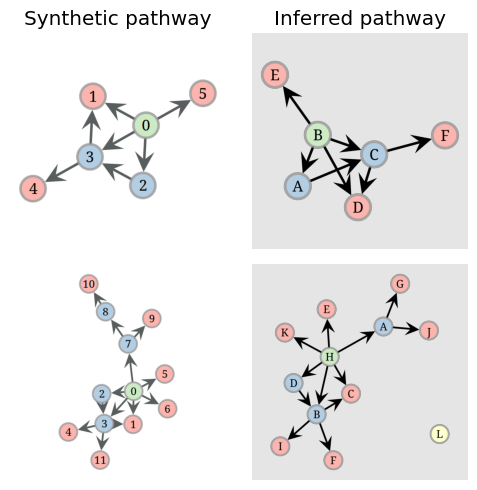

In [25]:
%matplotlib inline
from pathlib import Path

import yaml
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from plot import thesis_figure_formatting
from gallery import view_results
from image_processor import img_from_path, _plot_encodings, hide
from _constants import GTG_PLOT_ALPHA, GTG_SOFT_PLOT_ALPHA


experiment_names = ["experiment_04bb0f4", "experiment_d577d9d"]

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
# thesis_figure_formatting()

for ax_row, experiment_name in zip(axs, experiment_names):
    demo_experiment = Path("/workspaces/defrag/paper_experiments/demo_experiment/synthetic_data_experiment_30k_hierarchical_single_var") / experiment_name
    raw_data_path = demo_experiment / "final_representations.npz"
    raw_data = np.load(raw_data_path, allow_pickle=True)
    raw_data = {k: v for k, v in raw_data.items()}
    raw_data["pw_seq_embeddings"] = raw_data["pw_seq_embeddings"].item()
    cluster_labels = pd.read_csv(demo_experiment / "clustered_events.csv")

    # Read the cluster stats yaml file and print the AMI
    print(f"AMI: {yaml.load(open(demo_experiment / 'clustered_stats.yaml'), Loader=yaml.FullLoader)['ami']}")
    print(f"GED: {yaml.load(open(demo_experiment / 'defrag_results.yaml'), Loader=yaml.FullLoader)['edit_distance']}")
    print(f"WLGK: {yaml.load(open(demo_experiment / 'defrag_results.yaml'), Loader=yaml.FullLoader)['wlgk']}")

    ax_row[0].imshow(img_from_path(demo_experiment / "graph.png"))
    ax_row[1].imshow(img_from_path(demo_experiment / GTG_PLOT_ALPHA))

    for ax in ax_row:
        hide(ax)

axs[0][0].set_title("Synthetic pathway")
axs[0][1].set_title("Inferred pathway")

plt.tight_layout()
plt.savefig("paper_figures/demo_experiments_graphs_only.pdf", dpi=300)
plt.show()


96it [00:21,  4.38it/s]
96it [00:21,  4.52it/s]


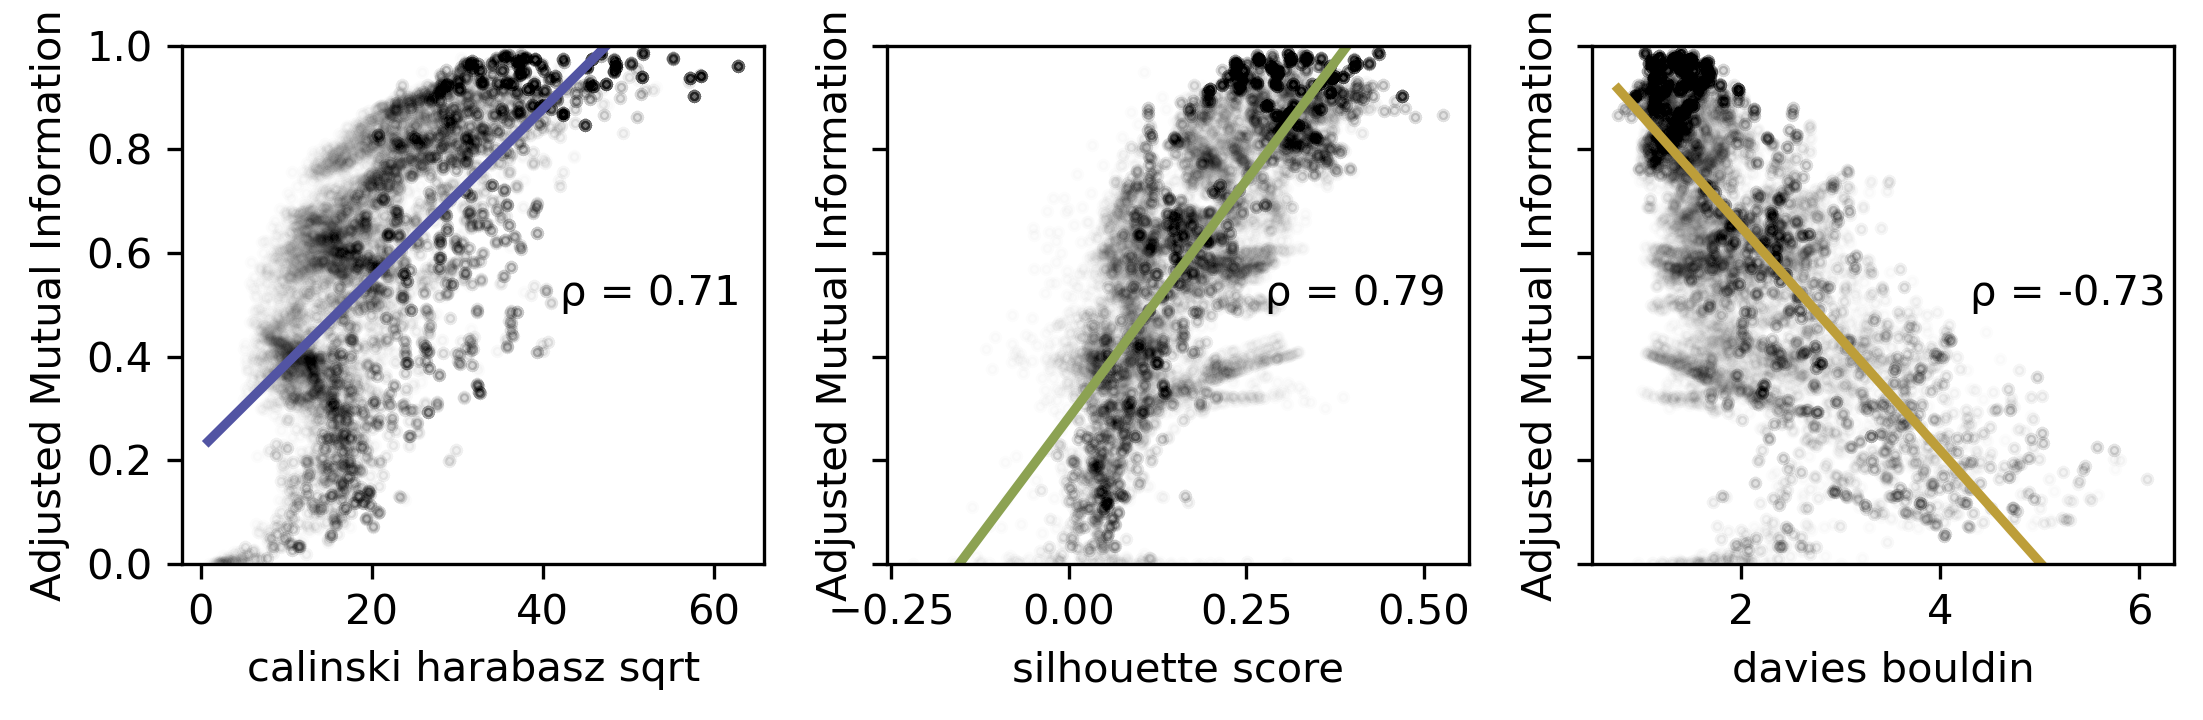

In [1]:
from pathlib import Path

import seaborn as sns
import yaml
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
from tqdm import tqdm

from plot import cmap40, thesis_figure_formatting, thesis_figure_save

# ROOT = Path("results_recreate_7_7_500_encodings")
# ROOT = Path("/workspaces/defrag/results_recreate_7_7_500_encodings/experiment_637ba7d")
ROOTS = [
    Path("paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big"),
    Path("paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big_1000_bins"),
]


stats_li = []
for ROOT in ROOTS:
    for stats_path in tqdm(ROOT.rglob("clustered_stats.yaml")):
        with open(stats_path, 'r') as f:
            stats = yaml.safe_load(f)
        stats_li += stats["clusterer_info"]["other_results"]#[:1]

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', sharey='row', xy=(.1, .7), xycoords=ax.transAxes)

# df = pd.DataFrame(search_results)
df = pd.DataFrame(stats_li)
df['sweet_spot'] = abs(df.num_clusters_ex_unknown - 12) <= 1
df
# map the floating point column ami_infer to an ordinal column in steps of 0.05
# df['ami_infer'] = df['ami_infer'].apply(lambda x: np.rint(x * 20) / 20)

# thesis_figure_formatting()
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5), sharey=True, dpi=300)
# from mpl_toolkits.axes_grid1 import ImageGrid
# grid = ImageGrid(
#     fig,                  
#     111,          # as in plt.subplot(111)                 
#     nrows_ncols=(1,3),                 
#     axes_pad=0.4,                 
#     share_y=True,                 
# )


df['calinski_harabasz sqrt_infer'] = np.sqrt(df['calinski_harabasz_infer'])

x_cols = ["calinski_harabasz sqrt_infer", "silhouette_score_infer", "davies_bouldin_infer"] # "relative_validity"]
y_col = "ami_infer"

colours = iter(cmap40)

for ax, x_col in zip(axs, x_cols):
    sns.regplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        color=next(colours), 
        ax=ax, 
        scatter=True, 
        order=1, 
        label=" ".join(x_col.split("_")[:2]),
        scatter_kws={"s": 5, "alpha": 0.01, "color": "black", "rasterized": True,},
    )
    ax.set_ylim(0, 1)
    ax.set_xlabel(" ".join(x_col.split("_")[:2]))
    ax.set_ylabel("Adjusted Mutual Information")
    r, _ = pearsonr(df[x_col], df[y_col])
    ax.annotate(f'ρ = {r:.2f}', xy=(.65, .5), xycoords=ax.transAxes)

fig.tight_layout()
plt.savefig("paper_figures/ami_vs_clustering_scores.pdf", bbox_inches="tight", dpi=300)
plt.show()

# df['calinski_harabasz_infer'] = np.sqrt(df['calinski_harabasz_infer'])
# g = sns.pairplot(
#     df, 
#     vars=["ami_infer", "calinski_harabasz_infer", "silhouette_score_infer", "davies_bouldin_infer"],#"ami_infer",  "silhouette_score_infer", "calinski_harabasz_score","davies_bouldin_score"],
#     # hue='ami_infer',
#     # diag_kind='hist',
#     # kind='reg',
#     # plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
# )
# g.map_lower(corrfunc)
# plt.show()


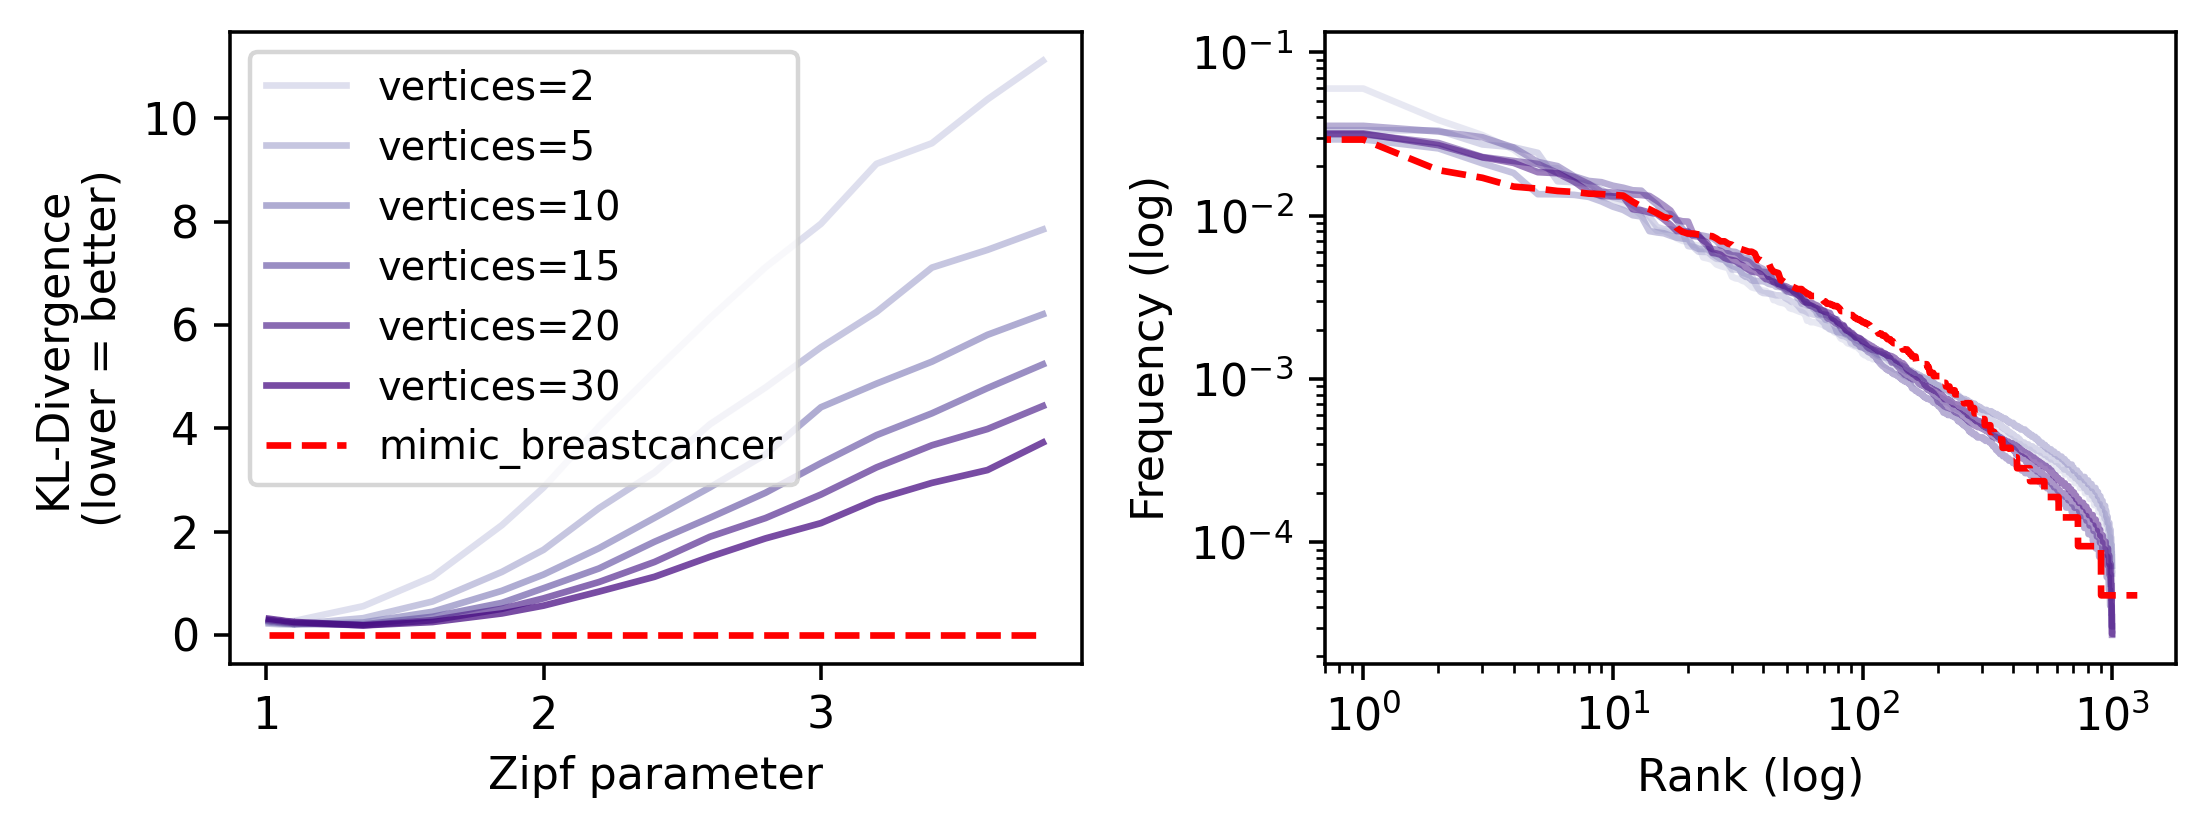

<Figure size 640x480 with 0 Axes>

In [8]:
from pathlib import Path
import sys
import shutil

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

from plot import thesis_figure_formatting, thesis_figure_save
from catsyn_config_generator import CatsynConfigFeedstock
from conductor import run_synthesis


%matplotlib inline

from plot import thesis_figure_formatting, thesis_figure_save

syn_vs_mimic_df = pd.read_parquet("statistical_experiments/grid_search_results_zipf_shuffle.parquet")
ref_infos = np.load("statistical_experiments/dataset_info.npz", allow_pickle=True)["data"].item(0)

ref_names = [
    # "mimic_full", "mimic_respiratory", "mimic_cancer", 
    "mimic_breastcancer"
]
# ref_name = "mimic_full"
for ref_name in ref_names:
    # thesis_figure_formatting()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.7), dpi=320)

    states = syn_vs_mimic_df.states.sort_values(ascending=True).unique()
    cm = plt.cm.Purples(np.linspace(0, 1, len(states) + 2))[2:]


    for idx, state in enumerate(states):
        _df = syn_vs_mimic_df[
            (syn_vs_mimic_df.ref_name == ref_name)
            & (syn_vs_mimic_df.states == state)
            & (syn_vs_mimic_df.bins == 1000)
            # & (syn_vs_mimic_df.a > 1.75)
        ]
        a = _df.sort_values(["a"], ascending=True)["a"].reset_index(drop=True, inplace=False)
        entropy = _df.sort_values(["a"], ascending=True)["entropy"].reset_index(drop=True, inplace=False)

        best_entropy = _df.sort_values(["entropy"], ascending=True).iloc[0]["entropy"]
        Q = _df.sort_values(["entropy"], ascending=True).iloc[0]["syn_f"]

        ax1.plot(a, entropy, color=cm[idx], alpha=0.7, label=f"vertices={state}")
        # ax1.plot(a[np.argmin(entropy)], [np.min(entropy)], 'o', color=cm[idx], label=f"KLD*={best_entropy:.2e}")
        # ax1.plot(a[np.argmin(entropy)], [np.min(entropy)], 'o')

        ax2.plot(np.arange(len(Q)), Q, label=f"vertices={state}", color=cm[idx], alpha=0.5)

    P = ref_infos[ref_name]["ref_f"]
    ax1.plot(a, [0 for _ in range(len(a))], "--", color="red", alpha=1, label=ref_name)
    ax2.plot(np.arange(len(P)), P, "--", color="red", alpha=1, label=ref_name)

    ax1.legend(loc="upper left", prop={'size': 9})
    # ax1.semilogy()
    # ax1.set_title(f"KL-Divergence of\npathway-synthetic data\nfrom {ref_name}")
    ax1.set_xlabel("Zipf parameter")
    ax1.set_ylabel(f"KL-Divergence\n(lower = better)")
    ax2.semilogx()
    ax2.semilogy()
    # ax2.legend()
    # ax2.set_title(f'Rank frequenceies of\n{ref_name} and best\nsynthetic approximations')
    ax2.set_xlabel("Rank (log)")
    ax2.set_ylabel("Frequency (log)")

    fig.tight_layout()
    # thesis_figure_save(Path("paper_figures"), f"pathway_synthetic_vs_{ref_name}")
    plt.savefig(f"paper_figures/pathway_synthetic_vs_{ref_name}.pdf")
    plt.show()
    plt.clf()



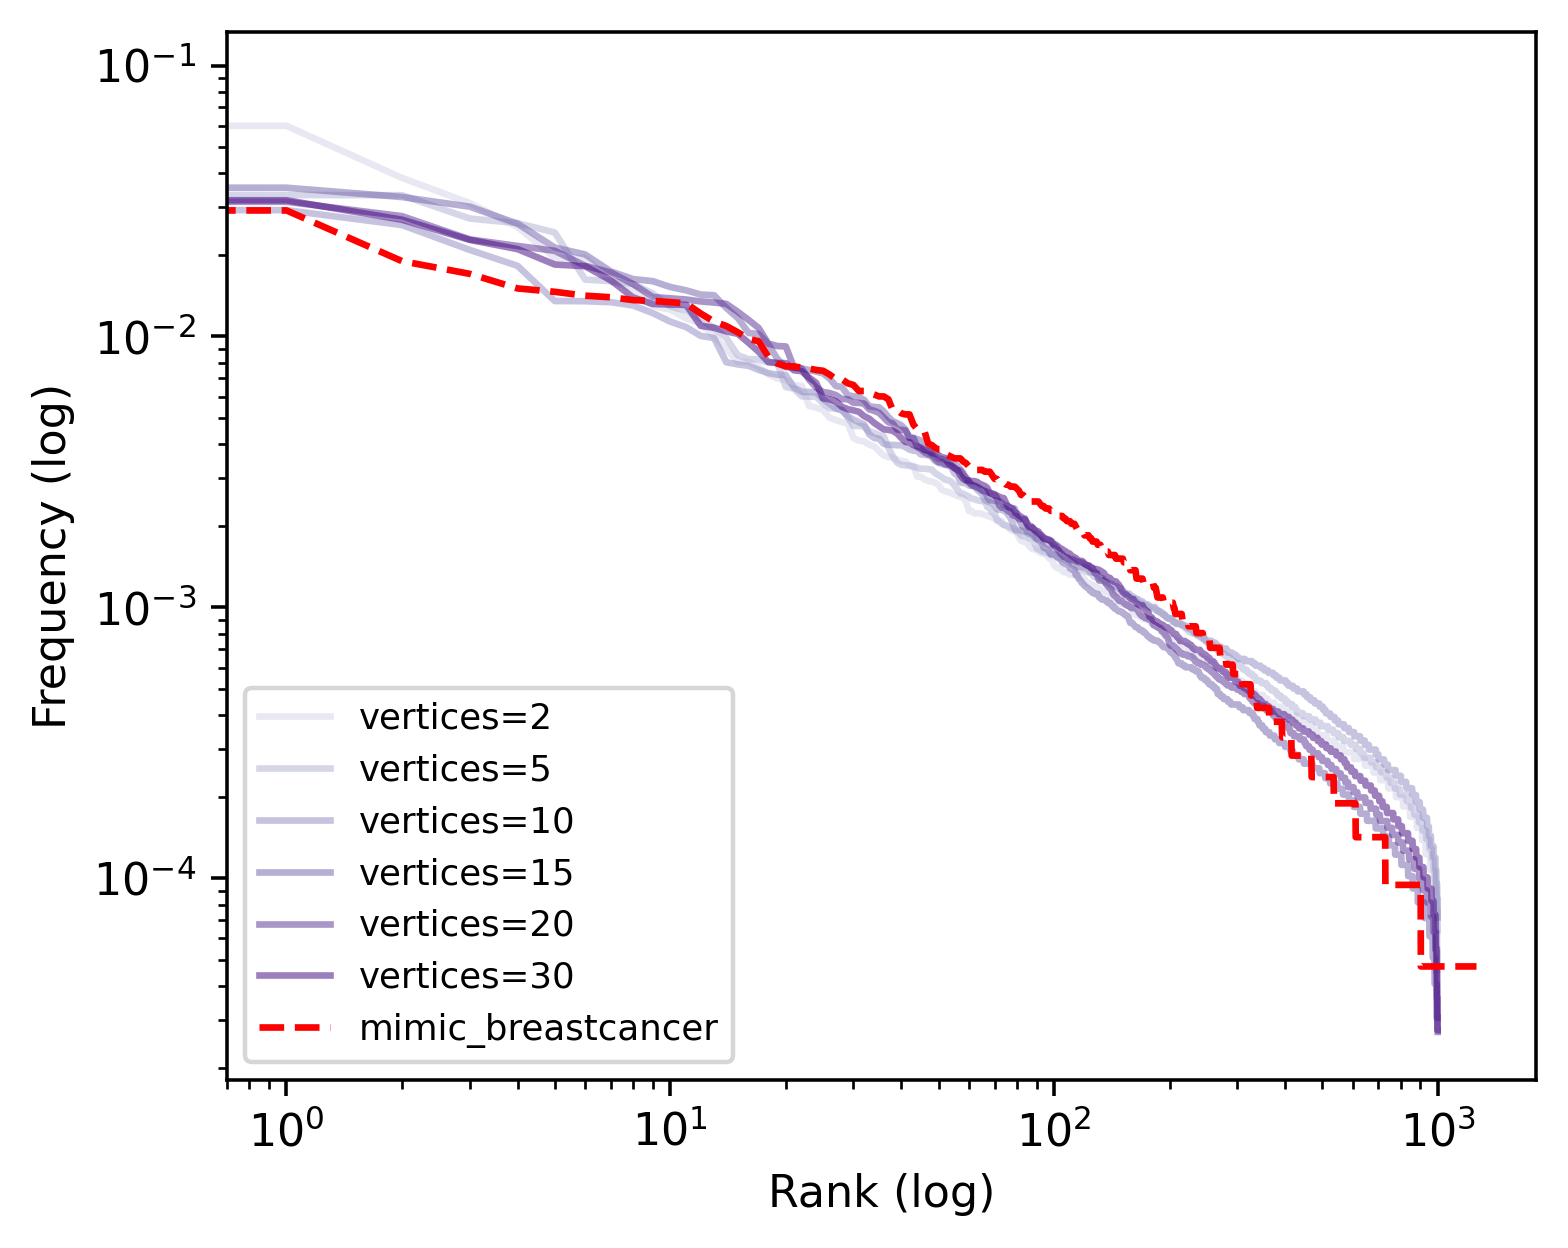

<Figure size 640x480 with 0 Axes>

In [7]:
from pathlib import Path
import sys
import shutil

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

from plot import thesis_figure_formatting, thesis_figure_save
from catsyn_config_generator import CatsynConfigFeedstock
from conductor import run_synthesis


%matplotlib inline

from plot import thesis_figure_formatting, thesis_figure_save

syn_vs_mimic_df = pd.read_parquet("statistical_experiments/grid_search_results_zipf_shuffle.parquet")
ref_infos = np.load("statistical_experiments/dataset_info.npz", allow_pickle=True)["data"].item(0)

ref_names = [
    # "mimic_full", "mimic_respiratory", "mimic_cancer", 
    "mimic_breastcancer"
]
# ref_name = "mimic_full"
for ref_name in ref_names:
    fig, ax2 = plt.subplots(1, 1, figsize=(4, 3), dpi=320)

    states = syn_vs_mimic_df.states.sort_values(ascending=True).unique()
    cm = plt.cm.Purples(np.linspace(0, 1, len(states) + 2))[2:]


    for idx, state in enumerate(states):
        _df = syn_vs_mimic_df[
            (syn_vs_mimic_df.ref_name == ref_name)
            & (syn_vs_mimic_df.states == state)
            & (syn_vs_mimic_df.bins == 1000)
            # & (syn_vs_mimic_df.a > 1.75)
        ]
        a = _df.sort_values(["a"], ascending=True)["a"].reset_index(drop=True, inplace=False)
        entropy = _df.sort_values(["a"], ascending=True)["entropy"].reset_index(drop=True, inplace=False)

        best_entropy = _df.sort_values(["entropy"], ascending=True).iloc[0]["entropy"]
        Q = _df.sort_values(["entropy"], ascending=True).iloc[0]["syn_f"]
        ax2.plot(np.arange(len(Q)), Q, label=f"vertices={state}", color=cm[idx], alpha=0.5)

    P = ref_infos[ref_name]["ref_f"]
    ax2.plot(np.arange(len(P)), P, "--", color="red", alpha=1, label=ref_name)

    ax2.legend(loc="lower left", prop={'size': 8})
    ax2.semilogx()
    ax2.semilogy()
    ax2.set_xlabel("Rank (log)")
    ax2.set_ylabel("Frequency (log)")

    fig.tight_layout()
    # thesis_figure_save(Path("paper_figures"), f"pathway_synthetic_vs_{ref_name}")
    # plt.savefig(f"paper_figures/pathway_synthetic_vs_{ref_name}.pdf")
    plt.show()
    plt.clf()



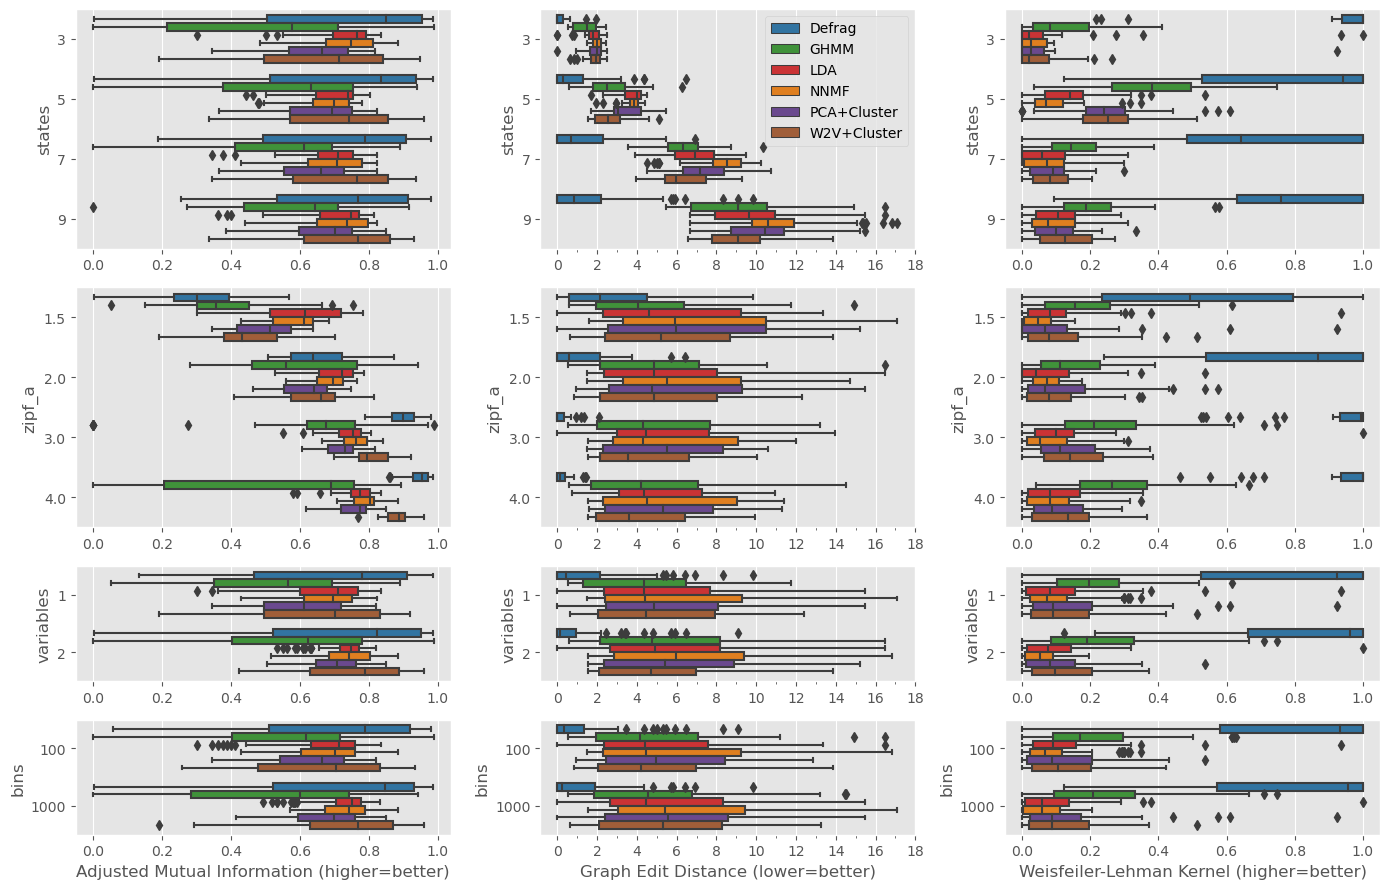

In [2]:
# Load lda results
from pathlib import Path
from plot import thesis_figure_formatting, thesis_figure_save

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from plot import cmap12

# def melt_df(df):
#     lda_cols = sorted([col for col in df.columns if col.startswith("LatentDirichletAllocation")])
#     nmf_cols = sorted([col for col in df.columns if col.startswith("Non-NegativeMatrixFactorization")])
#     pca_cols = sorted([col for col in df.columns if col.startswith("PCA+Cluster")])
#     defrag_cols = sorted([col for col in df.columns if col.startswith("Defrag")])
#     new_names = ["_".join(c.split("_")[1:]) for c in defrag_cols]
#     lda_df = df.drop(columns=(nmf_cols+pca_cols+defrag_cols)).rename(dict(zip(lda_cols, new_names)), axis=1)
#     nmf_df = df.drop(columns=(lda_cols+pca_cols+defrag_cols)).rename(dict(zip(nmf_cols, new_names)), axis=1)
#     pca_df = df.drop(columns=(lda_cols+nmf_cols+defrag_cols)).rename(dict(zip(pca_cols, new_names)), axis=1)
#     defrag_df = df.drop(columns=(lda_cols+nmf_cols+pca_cols)).rename(dict(zip(defrag_cols, new_names)), axis=1)
#     lda_df["method"] = "LatentDirichletAllocation"
#     nmf_df["method"] = "Non-negativeMatrixFactorisation"
#     pca_df["method"] = "PCA+Cluster"
#     defrag_df["method"] = "Defrag (ours)"
#     return pd.concat([lda_df, nmf_df, pca_df, defrag_df]).reset_index(drop=True)

def melt_df(df):
    # melt the df
    df = pd.melt(
        df, 
        id_vars=["experiment_name", "seed", "zipf_a", "states", "variables", "bins", "n_topics", "steps"], 
        var_name="var",
        value_name="value"
    )
    # split the 'var' column into method, ami and score
    df[["method", "measure"]] = df["var"].str.split("_", n=1, expand=True)
    df = df.drop("var", axis=1)
    df = df.pivot_table(index=["experiment_name", "seed", "zipf_a", "states", "variables", "bins", "n_topics", "steps", "method"], columns="measure", values="value").reset_index()
    # convert data types
    df["is_isomorphic"] = df["is_isomorphic"].astype(bool)
    df["syn_contains_inf"] = df["syn_contains_inf"].astype(bool)
    df["inf_contains_syn"] = df["inf_contains_syn"].astype(bool)
    df["approx_ged"] = df["approx_ged"].astype(bool)
    # Fix edit distance of null
    df["edit_distance"] = df.apply(lambda x: 0 if pd.isna(x["edit_distance"]) and x["is_isomorphic"] else x["edit_distance"], axis=1)

    return df

def plot_lda_results(df, save_path: str = None):
    df = melt_df(df)
    # df = df[df.variables == 1]
    # print types for each column in the df
    df['variables'] = df.variables.astype('category')
    df['bins'] = df.bins.astype('category')
    df['states'] = df.states.astype('category')
    df['zipf_a'] = df.zipf_a.astype('category')
    df['method'] = df['method'].apply(lambda x: "W2V+Cluster" if x == "Word2Vec" else x)
    df['method'] = df['method'].apply(lambda x: "PCA+Cluster" if x == "PCA+Cluster" else x)
    df['method'] = df['method'].apply(lambda x: "NNMF" if x == "Non-NegativeMatrixFactorization" else x)
    df['method'] = df['method'].apply(lambda x: "LDA" if x == "LatentDirichletAllocation" else x)
    # Add a bit of jitter
    df['edit_distance'] = np.clip(
        df.edit_distance + np.random.uniform(-0.5, 0.5, df.edit_distance.__len__()), 
        0,
        df.edit_distance.max() + 1
    )
    df['wlgk'] = np.clip(
        df.wlgk + np.random.uniform(-0.1, 0.1, df.wlgk.__len__()), 
        df.wlgk.min(),
        df.wlgk.max()
    )

    # df['ami'] = df.states.astype(float)
    # df['edit_distance'] = df.states.astype(float)

    # if LAYOUT == "tall":
    #     fig, axs = plt.subplots(2, 1, figsize=(8, 5))
    # if LAYOUT == "wide":
    #     fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 3.5))
    fig, axs = plt.subplots(
        4, 
        3, 
        figsize=(14, 9),
        gridspec_kw={'height_ratios':[1, 1, .48, .48]}
    )#, sharey='row', )
    y_cols = ["states", "zipf_a", "variables", "bins"]
    for y_col, ax in zip(y_cols, axs):
        sns.boxplot(data=df, x="ami", y=y_col, hue="method", ax=ax[0], palette=cmap12)
        ax[0].legend().set_visible(False)
        ax[0].set(xlabel=None)

        sns.boxplot(data=df, x="edit_distance", y=y_col, hue="method", ax=ax[1], palette=cmap12)
        # Set x ticks at 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
        ax[1].set_xticks(np.arange(0, 20, 2))
        # Set minor ticks for every integer
        ax[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
        ax[1].legend().set_visible(False)
        ax[1].set(xlabel=None)

        sns.boxplot(data=df, x="wlgk", y=y_col, hue="method", ax=ax[2], palette=cmap12)
        # Set x ticks at 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
        ax[2].set_xticks(np.arange(0.0, 1.2, 0.2))
        # Set minor ticks for every integer
        ax[2].xaxis.set_minor_locator(plt.MultipleLocator(1))
        ax[2].legend().set_visible(False)
        ax[2].set(xlabel=None)

    axs[-1, 0].get_xaxis().set_visible(True)
    axs[-1, 1].get_xaxis().set_visible(True)
    axs[-1, 0].set_xlabel('Adjusted Mutual Information (higher=better)')
    axs[-1, 1].set_xlabel('Graph Edit Distance (lower=better)')
    axs[-1, 2].set_xlabel('Weisfeiler-Lehman Kernel (higher=better)')
    axs[0, 1].legend().set_visible(True)
    return None

# ----

df = pd.concat([
    # pd.read_csv(Path("/workspaces/defrag/paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big") / "lda_results_allmethods.csv"),
    # pd.read_csv(Path("/workspaces/defrag/paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big_1000_bins") / "lda_results_allmethods.csv"),
    # pd.read_csv(Path("/workspaces/defrag/paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big") / "lda_results_w2v.csv"),
    # pd.read_csv(Path("/workspaces/defrag/paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big_1000_bins") / "lda_results_w2v.csv"),
    pd.read_csv(Path("/workspaces/defrag/paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big") / "lda_results_wlgk_2.csv"),
    pd.read_csv(Path("/workspaces/defrag/paper_experiments/synthetic_benchmarks/synthetic_data_experiment_big_1000_bins") / "lda_results_wlgk_2.csv"),
    # pd.read_csv(Path("/workspaces/defrag/experiments/synthetic_data_experiment_big") / "lda_results_window2.csv"),
    # pd.read_csv(Path("/workspaces/defrag/experiments/synthetic_data_experiment_big_1000_bins") / "lda_results_window2.csv"),
])

LAYOUT = "tall"
# LAYOUT = "tall"
thesis_figure_formatting()
plot_lda_results(df)#, "paper_figures/synthetic_data_experiment_big_1000_bins.pdf")
plt.tight_layout()
# plt.savefig("paper_figures/defrag_synthetic_benchmarks.pdf")
plt.show()


In [44]:
from IPython.display import display

def mean_summarise(scores):
    scores = pd.Series(scores)
    # Return the median and the 95% confidence interval, all to 2dp
    return f"{scores.mean():.2f} ({scores.std():.2f})" #[{scores.quantile(0.25):.2f}, {scores.quantile(0.75):.2f}]"
    # return f"{scores.mean():.2f} (±{scores.std():.2f})"
def median_summarise(scores):
    scores = pd.Series(scores)
    # Return the median and the 95% confidence interval, all to 2dp
    return f"{scores.median():.2f} ({scores.std():.2f})" #[{scores.quantile(0.25):.2f}, {scores.quantile(0.75):.2f}]"
    # return f"{scores.median():.2f} (±{scores.mad():.2f})"

display_df = melt_df(df)[[
    "method", 
    "ami", 
    "edit_distance", 
    "weisfeiler_lehman_kernel",
    "weisfeiler_lehman_kernel_worst_case",
    "wlgk"
    # "is_isomorphic"
]].groupby(by="method").agg(
    {
        'ami': median_summarise, 
        'edit_distance': mean_summarise, 
        'wlgk': mean_summarise,
        # 'ami': ["median",], 
        # 'edit_distance': ['mean',], 
        # 'is_isomorphic': ['mean',], 
    }
)
display(display_df)

display_df = display_df.style.format(precision=2)
print(display_df.to_latex())

# #  mean())
# display(melt_df(df)[["method", "ami"]].groupby(by="method").median())
# display(melt_df(df)[["method", "edit_distance"]].groupby(by="method").mean())


measure                                  ami edit_distance         wlgk
method                                                                 
Defrag                           0.81 (0.27)   1.03 (1.85)  0.80 (0.29)
GHMM                             0.61 (0.26)   4.93 (3.44)  0.21 (0.16)
LatentDirichletAllocation        0.74 (0.10)   5.54 (3.34)  0.09 (0.13)
Non-NegativeMatrixFactorization  0.72 (0.10)   6.31 (3.90)  0.06 (0.06)
PCA+Cluster                      0.68 (0.12)   5.78 (3.58)  0.10 (0.13)
Word2Vec                         0.75 (0.18)   5.06 (3.20)  0.12 (0.10)

\begin{tabular}{llll}
{measure} & {ami} & {edit_distance} & {wlgk} \\
{method} & {} & {} & {} \\
Defrag & 0.81 (0.27) & 1.03 (1.85) & 0.80 (0.29) \\
GHMM & 0.61 (0.26) & 4.93 (3.44) & 0.21 (0.16) \\
LatentDirichletAllocation & 0.74 (0.10) & 5.54 (3.34) & 0.09 (0.13) \\
Non-NegativeMatrixFactorization & 0.72 (0.10) & 6.31 (3.90) & 0.06 (0.06) \\
PCA+Cluster & 0.68 (0.12) & 5.78 (3.58) & 0.10 (0.13) \\
Word2Vec & 0.75 (0.18) & 5.06 (3.20) & 0.12 (0.10) \\
\end{tabular}



In [8]:
from scipy.stats import wilcoxon

_df = melt_df(df)
for method in _df.method.unique():
    # results compared to the "Drfrag" method results
    if method != "Defrag":
        print(method)
        print(wilcoxon(_df[_df.method == method].ami, _df[_df.method == "Defrag"].ami))
        print(wilcoxon(_df[_df.method == method].edit_distance, _df[_df.method == "Defrag"].edit_distance))
        print()
    

HMM
WilcoxonResult(statistic=3642.0, pvalue=3.057616612547127e-13)
WilcoxonResult(statistic=576.5, pvalue=6.965240670017037e-29)

LatentDirichletAllocation
WilcoxonResult(statistic=8605.0, pvalue=0.39269796355838815)
WilcoxonResult(statistic=33.5, pvalue=1.3915532554953681e-31)

Non-NegativeMatrixFactorization
WilcoxonResult(statistic=8698.0, pvalue=0.4628803824343226)
WilcoxonResult(statistic=31.5, pvalue=1.382359272601226e-32)

PCA+Cluster
WilcoxonResult(statistic=5987.0, pvalue=2.13457862036068e-05)
WilcoxonResult(statistic=12.0, pvalue=7.661065562182727e-33)



/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

Using soft GTG plot


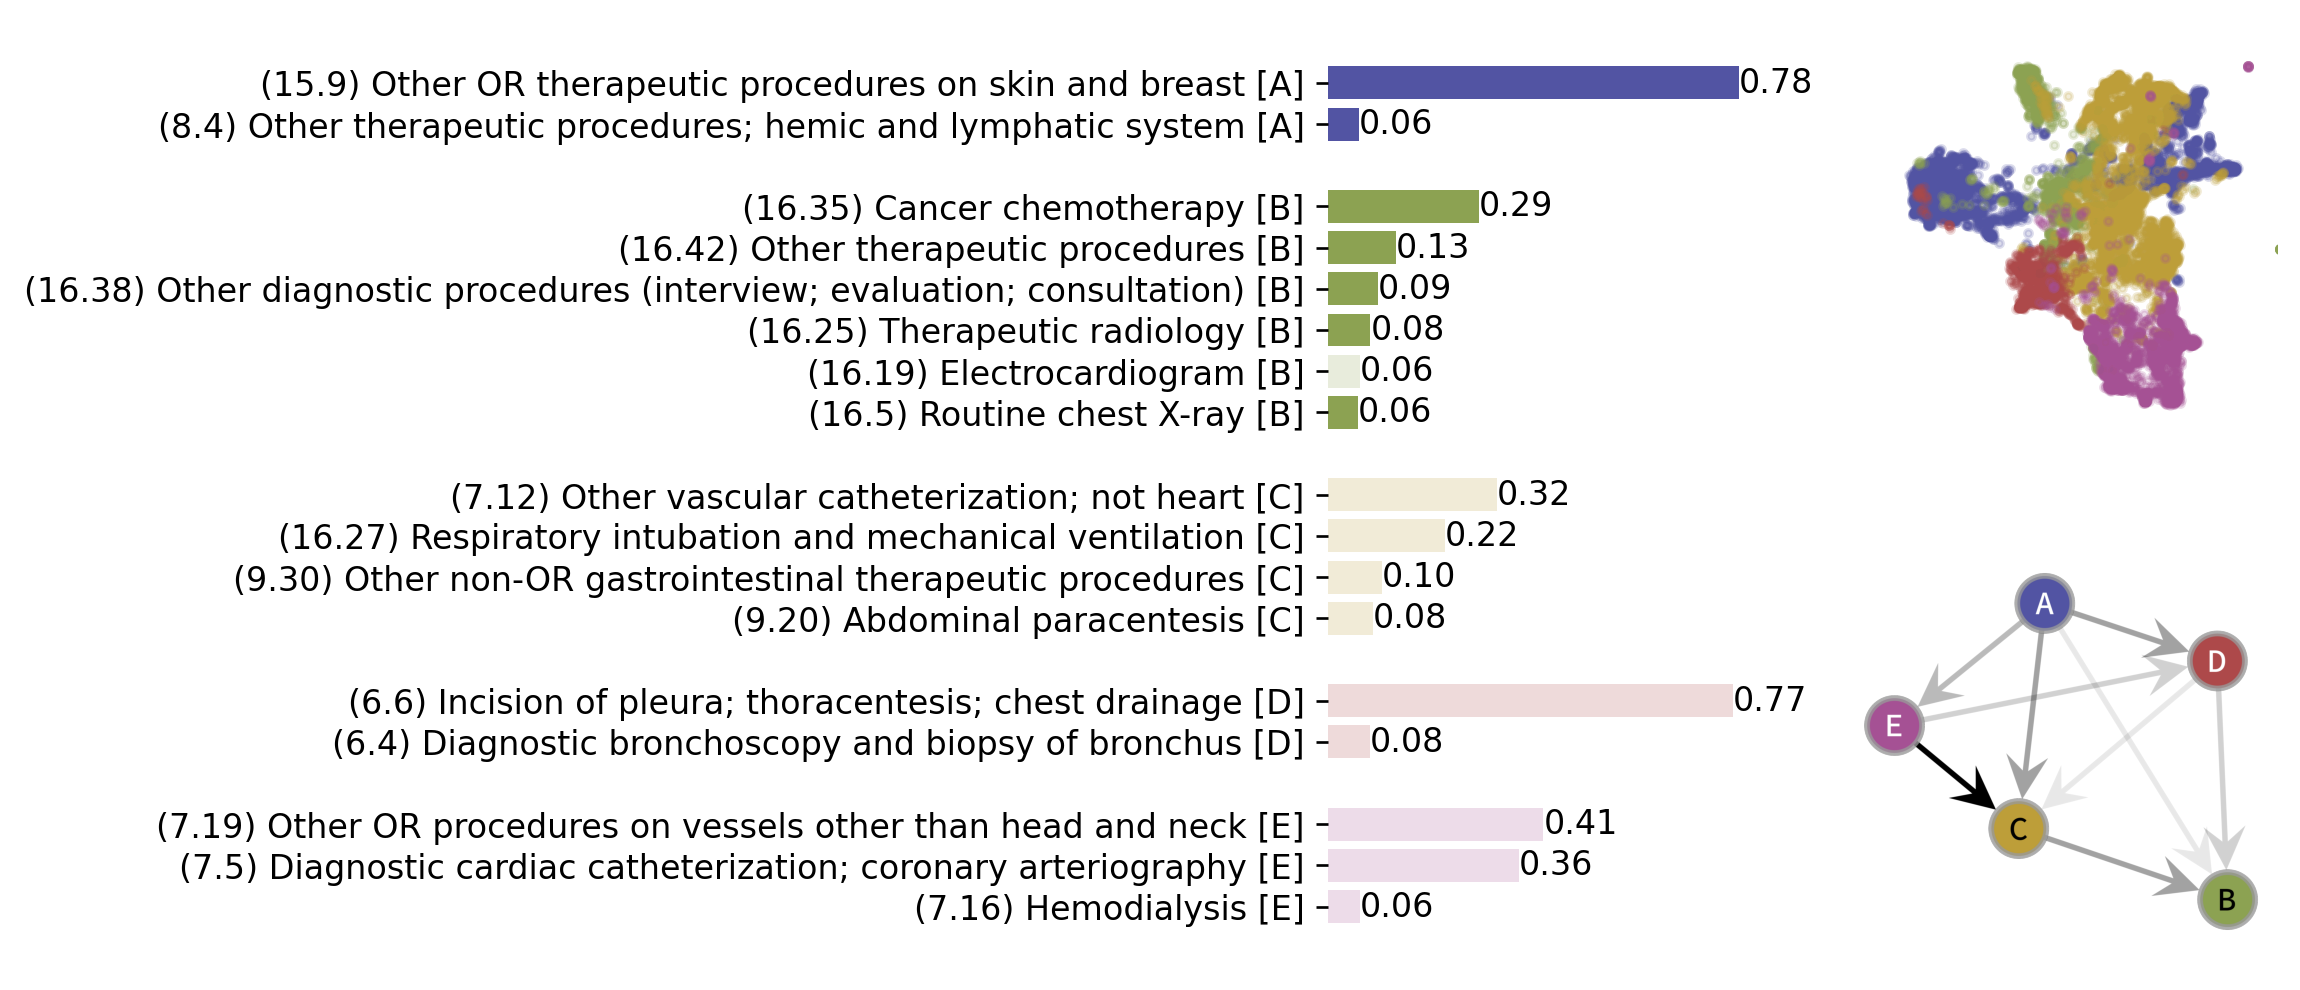

Using soft GTG plot


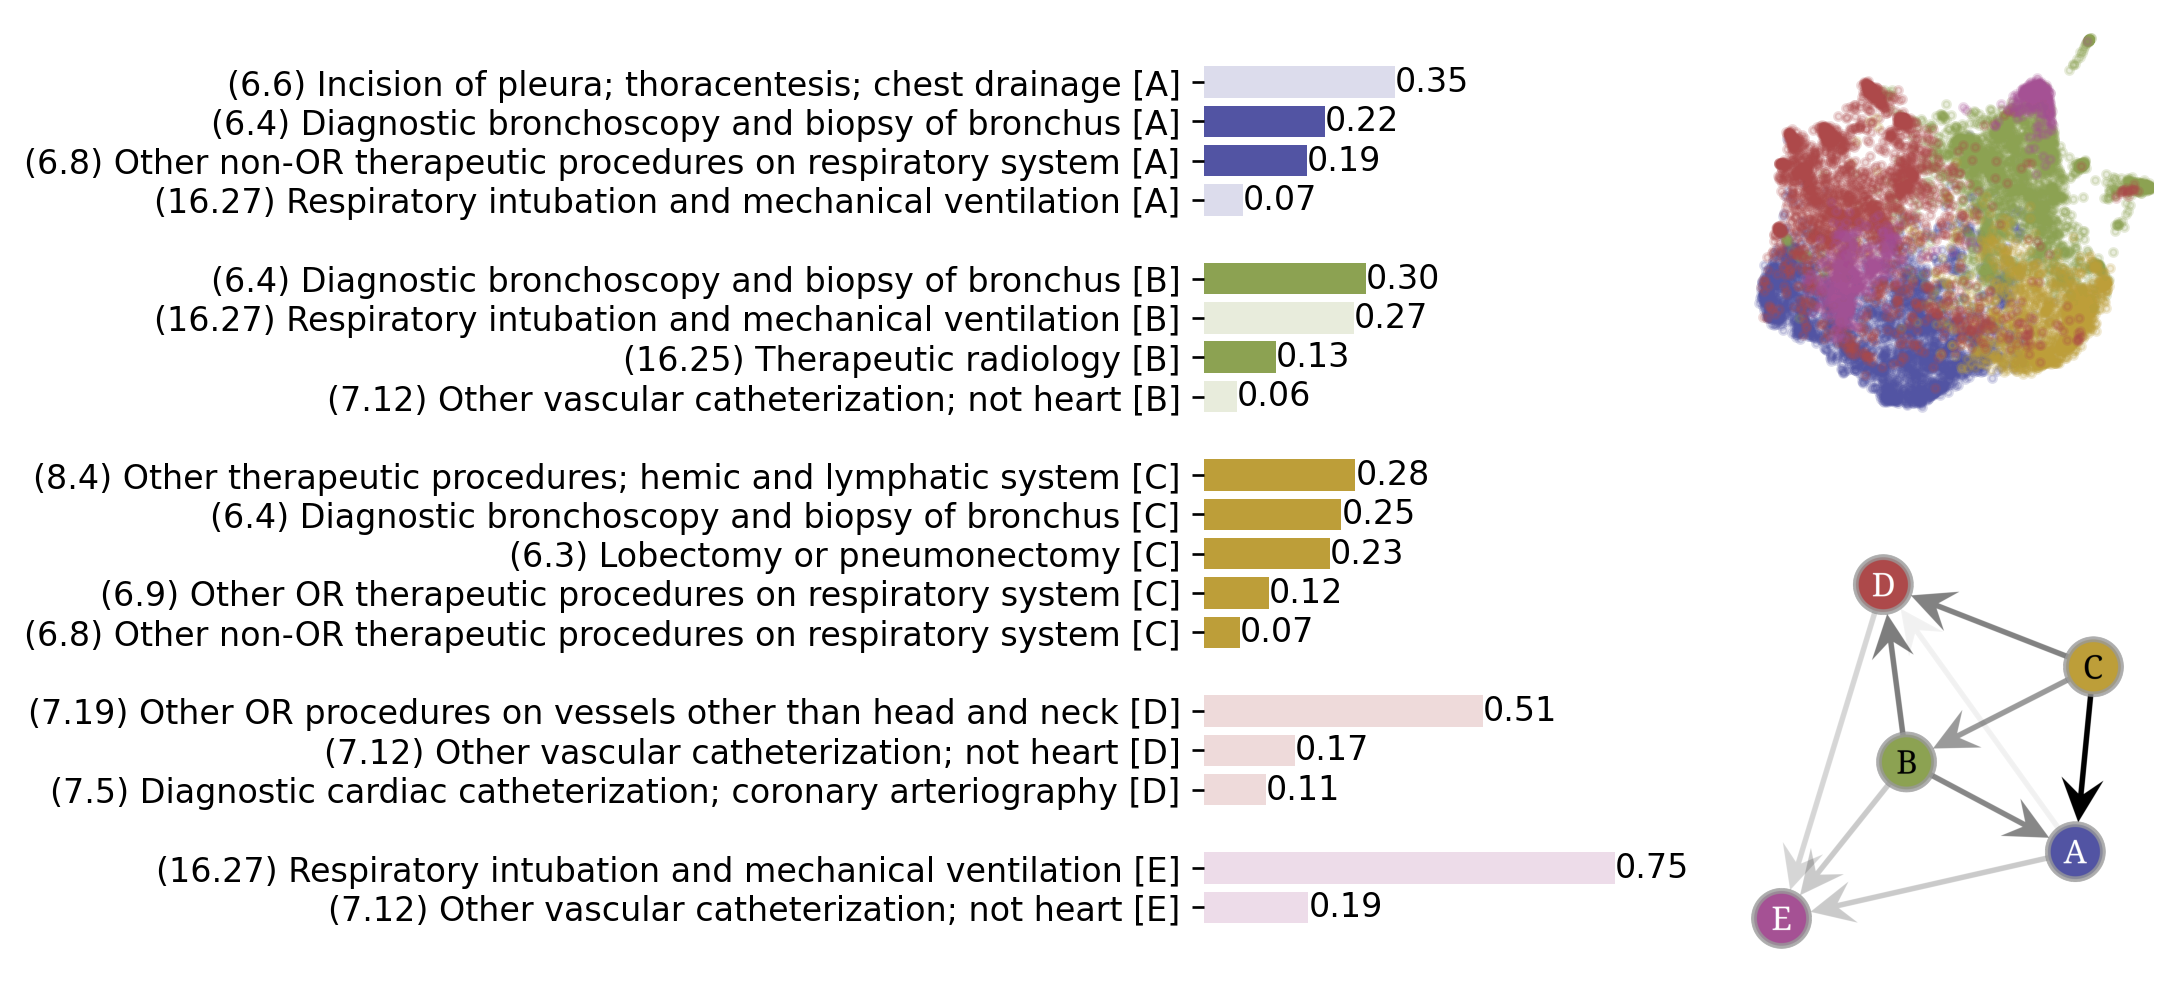

Using soft GTG plot


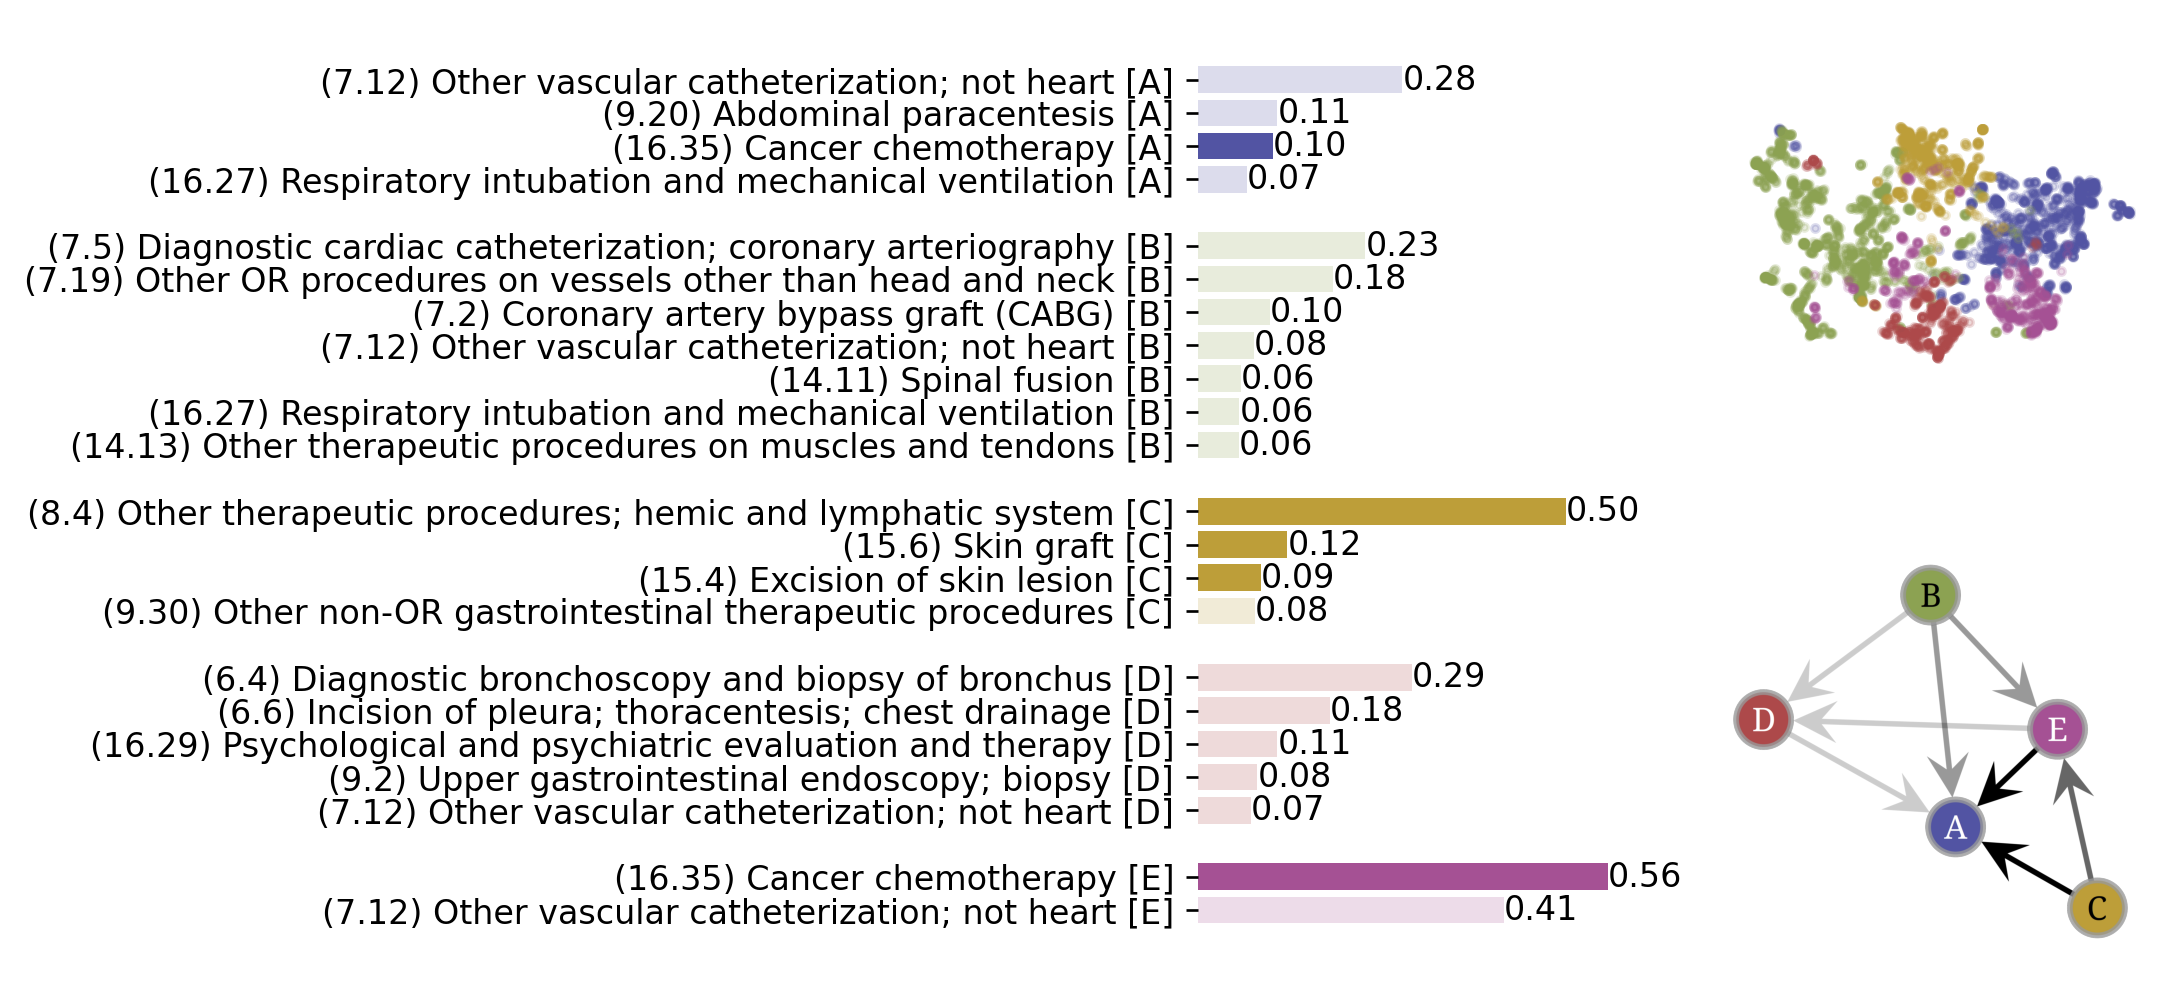

In [8]:
# Recreate the MIMIC-IV experiment plots for breast, lung, and melanoma
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
import seaborn as sns

from defrag import Defrag
from _constants import DEFRAG_DATA

PATHS = [
    "/workspaces/defrag/paper_experiments/mimic_experiment_breast_soft_hierarchical_5/experiment_88c089e",
    "/workspaces/defrag/paper_experiments/mimic_experiment_lung_soft_hierarchical_5/experiment_7470748",
    "/workspaces/defrag/paper_experiments/mimic_experiment_melanoma_soft_hierarchical_5/experiment_299625e",
]

from image_processor import MimicExperimentProcessor

MimicExperimentProcessor(
    experiment_path=Path(PATHS[0]),
    relevant_codes_only=True,
    save=True,
    save_path=Path("paper_figures/mimic_breast_results.pdf"),
    fig_size_multiplier=0.85,
).run()

MimicExperimentProcessor(
    experiment_path=Path(PATHS[1]),
    relevant_codes_only=True,
    save=True,
    save_path=Path("paper_figures/mimic_lung_results.pdf"),
    fig_size_multiplier=0.85,
).run()
MimicExperimentProcessor(
    experiment_path=Path(PATHS[2]),
    relevant_codes_only=True,
    save=True,
    save_path=Path("paper_figures/mimic_melanoma_results.pdf"),
    fig_size_multiplier=0.85,
).run()

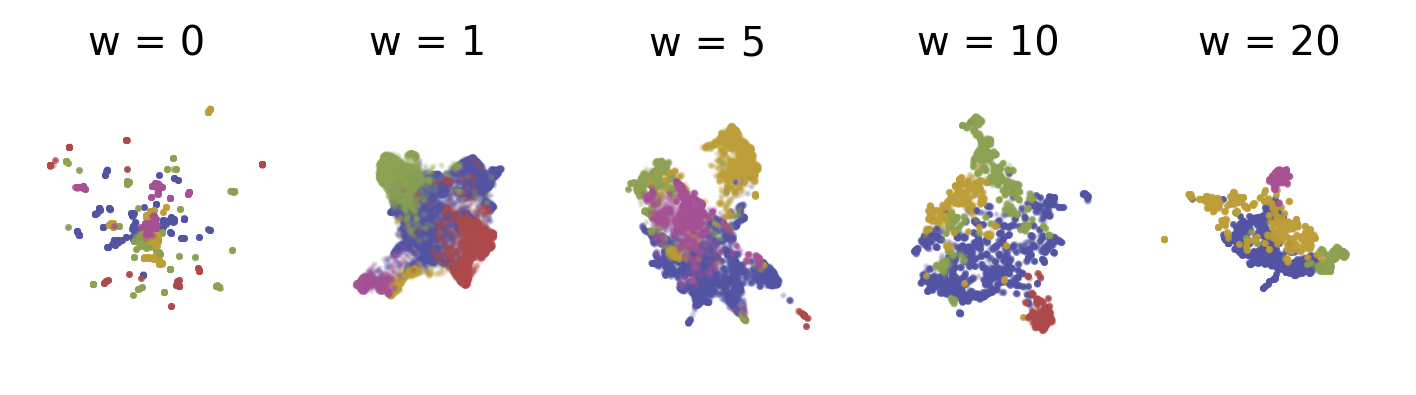

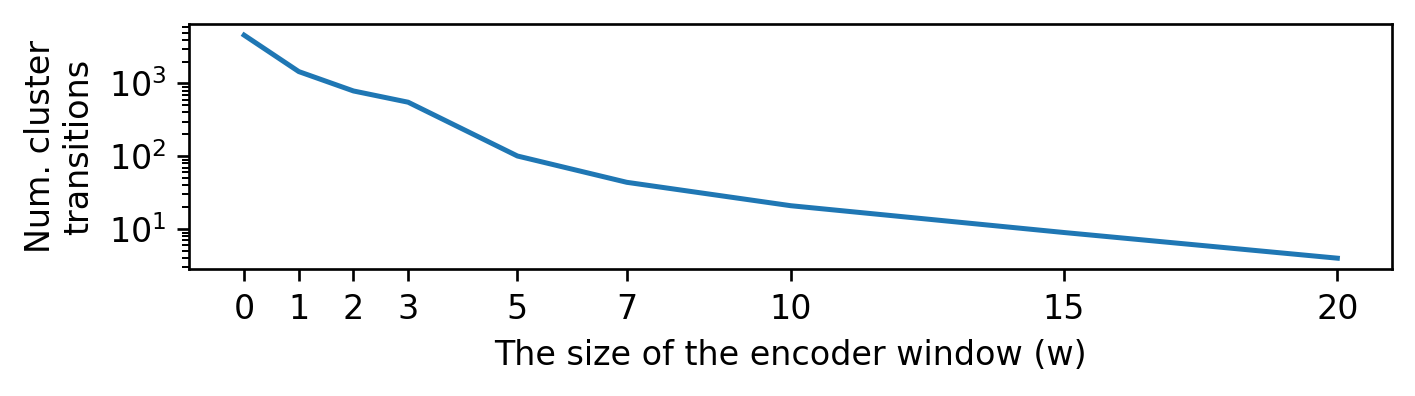

In [9]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def count_num_edges(experiment_path): 
    window = int(str(experiment_path).split("_")[-1])
    defrag_data = np.load(next(experiment_path.rglob("defrag_data.npz")))
    diag_count = defrag_data["ram"].diagonal().sum()
    non_diag = defrag_data["ram"].copy()
    np.fill_diagonal(non_diag, 0)
    non_diag_count = non_diag.sum()
    return dict(window_size=window, diag_count=diag_count, non_diag_count=non_diag_count, total=defrag_data["ram"].copy().sum())


experiments = list(Path("paper_experiments/window_size_experiments/").glob("mimic_experiment_breast_soft_window_*"))
# experiments = [e for e in experiments if "_5" not in str(e)]
experiments.sort(key=lambda x: int(str(x).split("_")[-1]))

df = pd.DataFrame([count_num_edges(exp) for exp in experiments])

from image_processor import MimicExperimentProcessor

window_numbers_to_plot = [0, 1, 5, 10, 20]
# Get experiments with the window numbers above
umaps_to_plot = [e for e in experiments if int(str(e).split("_")[-1]) in window_numbers_to_plot]

fig, axs = plt.subplots(ncols=len(window_numbers_to_plot), nrows=1, figsize=(6, 1.75), dpi=240)
# For each plot on the top row, instantiate MimicExperimentProcessor and call plot_clusterings on
# the axis
for (i, ax), exp in zip(enumerate(axs), umaps_to_plot):
    # The experiment is actually the lone folder in the experiment directory. Find it
    exp_path = next(exp.rglob("experiment_*"))
    proc = MimicExperimentProcessor(Path(exp_path))
    proc.plot_clusterings(ax=ax, eoi=proc.experiment_path, focus=True, s=1)
    ax.set_title(f"w = {window_numbers_to_plot[i]}")

plt.tight_layout()
# plt.savefig("paper_figures/encoder_window_size_demo_top.pdf", bbox_inches="tight", dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 1.75), dpi=240)

sns.lineplot(data=df, x="window_size", y="non_diag_count")#, ax=ax)
# Set the x label to "The size of the encoder window"
plt.xlabel("The size of the encoder window (w)")
# Set the y label to the number of cluster transitions
plt.ylabel("Num. cluster\ntransitions")
plt.xticks(df["window_size"])
plt.semilogy()

plt.tight_layout()
# plt.savefig("paper_figures/encoder_window_size_demo_bottom.pdf", bbox_inches="tight", dpi=300)
plt.show()



/tmp/ipykernel_2473548/3215783703.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


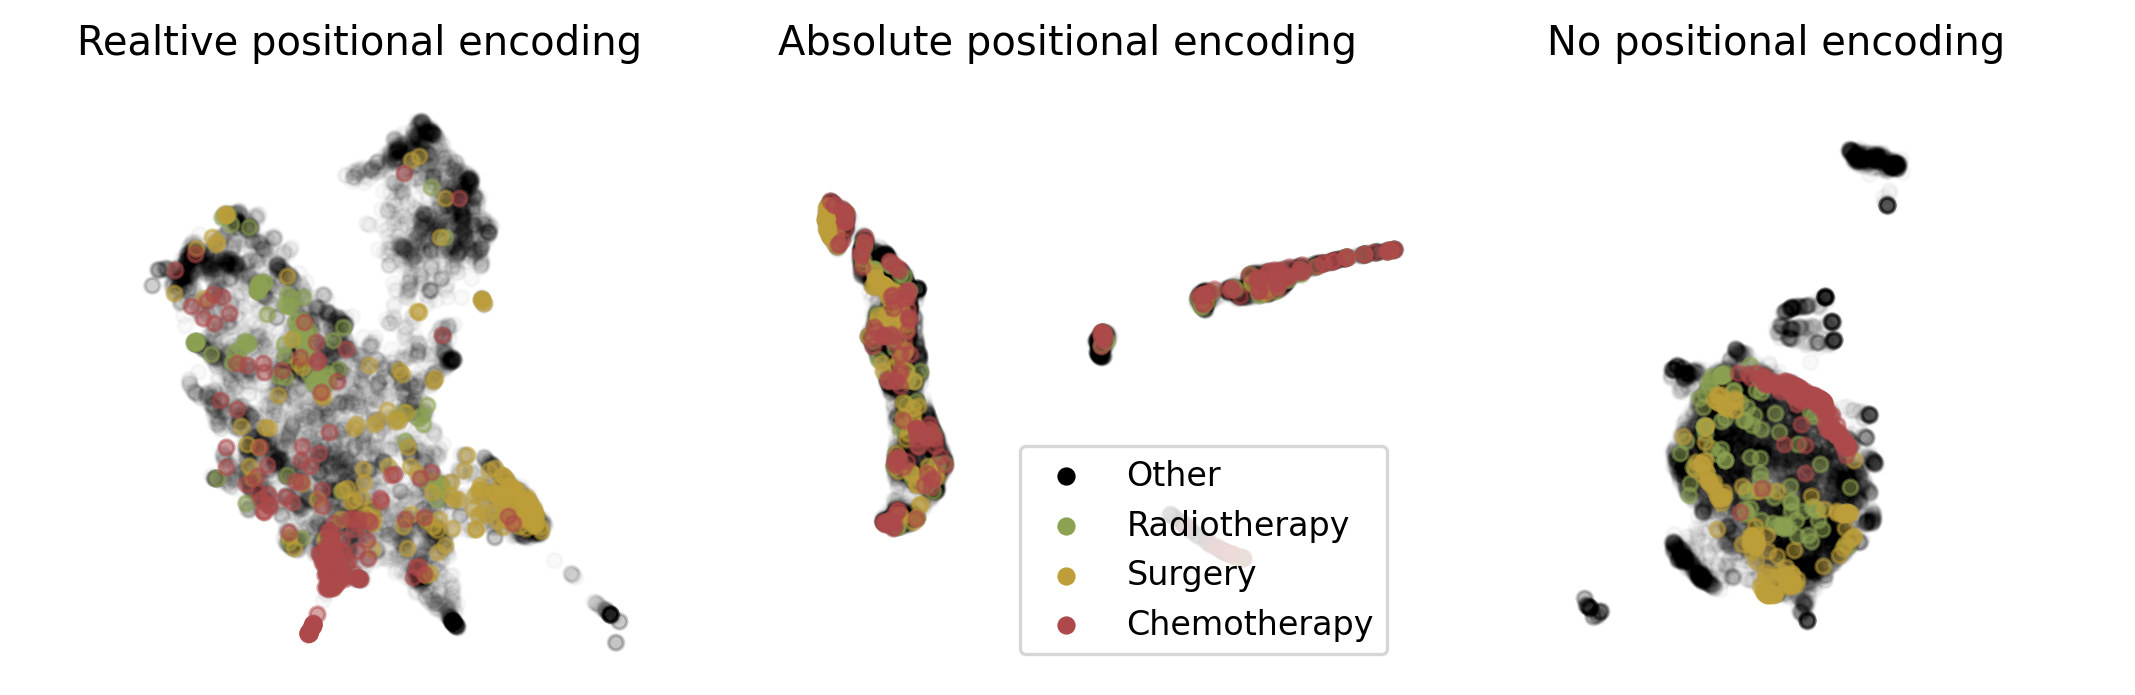

In [10]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from image_processor import _plot_encodings, hide


experiments = {
    "Realtive positional encoding": Path("paper_experiments/window_size_experiments/mimic_experiment_breast_soft_window_5/"),
    "Absolute positional encoding": Path("paper_experiments/positional_encoding_ablation/mimic_experiment_breast_soft_window_5/"),
    "No positional encoding": Path("paper_experiments/no_positional_encoding_ablation/mimic_experiment_breast_soft_window_5"),
}

fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=240)

for (name, exp), ax in zip(experiments.items(), axs):
    labels = pd.read_csv(next(exp.rglob("clustered_events.csv")))["y"]
    encodings = np.load(next(exp.rglob("final_representations.npz")))["embeddings"]
    assert len(labels) == encodings.shape[0]
    labels = labels.replace('15.1_SD', 'Surgery', regex=False)
    labels = labels.replace('16.37_SD', 'Radiotherapy', regex=False)
    labels = labels.replace('16.35_SD', 'Chemotherapy', regex=False)
    ax.set_title(name)
    _plot_encodings(
        umap_embeddings=encodings,
        dataset_targets=labels,
        ax=ax,
        focus=True,
        alpha=0.5,
        s=20,
    )
    if name == "Absolute positional encoding":
        legend_labels = pd.Series(labels.unique()).replace("Unspecified", "Other").tolist()#['Other', 'Surgery', 'Radiology', 'Chemotherapy']
        legend = ax.legend(labels=legend_labels)
        for lh in legend.legendHandles:
            lh.set_alpha(1)
    hide(ax)
    # break

plt.tight_layout()
plt.savefig("paper_figures/positional_encoding_ablation.pdf", bbox_inches="tight", dpi=300)

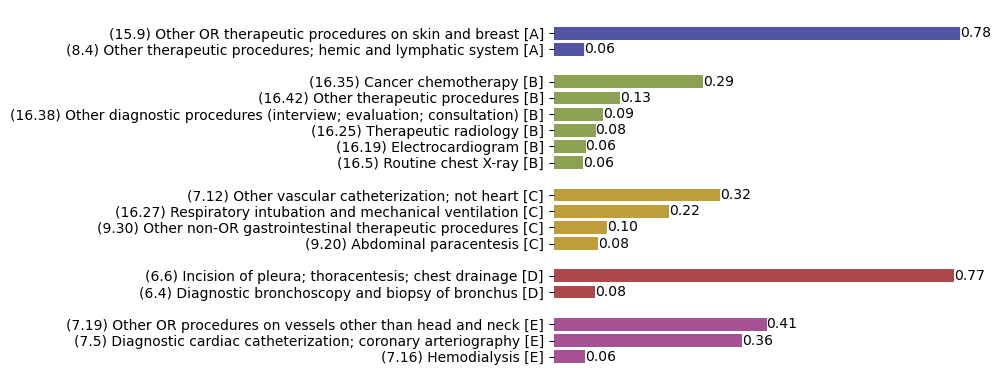

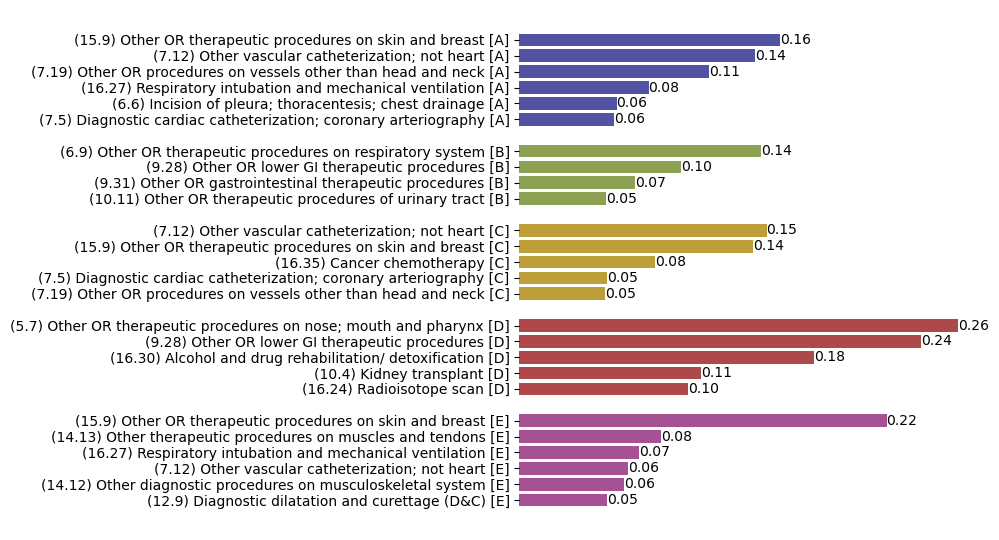

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy

from image_processor import MimicExperimentProcessor, CMAP


stlo = Path("paper_experiments/mimic_experiment_breast_soft_hierarchical_5")
mse  = Path("paper_experiments/mimic_experiment_breast_soft_window_5_mse")


def plot_cluster_stats(processor: MimicExperimentProcessor, cluster_stats, ax):
    stats = {k: processor.filter_cluster_codes(v) for k, v in cluster_stats.items()}
    colour_list = CMAP
    full_stats = pd.concat(list(map(lambda x: pd.concat((x, pd.Series([np.nan], index=[""]))), stats.values())))[:-1]
    clusters = [cl if idx < len(df) else "" for cl, df in stats.items() for idx in range(len(df) + 1)][:-1]
    full_colours = pd.Series([idx for idx, series in enumerate(stats.values()) for _ in range(len(series) + 1)])[:-1]
    codes = full_stats.index
    codes = pd.Series(list(f"{code} [{cluster}]" if code != "" else "" for code, cluster in zip(full_stats.index, clusters)))
    codes_ratios = full_stats.values
    y_pos = np.arange(len(codes))
    y_pos_ticks = [idx for idx in np.arange(len(codes)) if pd.notnull(codes_ratios[idx])]
    colours_list = [colour_list[colour_idx] for colour_idx in full_colours]
    alphas_list = [processor.get_alpha(code) for code in codes]
    rgba = [(*c, a) for c, a in zip(colours_list, alphas_list)]
    hbars = ax.barh(
        y_pos, 
        codes_ratios, 
        align='center', 
        color=rgba,
    )
    # ax.set_xlim([0, 1])
    ax.set_yticks(y_pos_ticks, labels=codes[codes != ""])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Code distribution')
    processor.hide(ax, yax=False)
    ax.bar_label(hbars, fmt='%.2f')


def get_cluster_entropies(experiment_path: Path, ax):
    experiment_path  = next(experiment_path.rglob("experiment_*"))  # This is a sub-experiment dir
    processor = MimicExperimentProcessor(experiment_path)
    cluster_labels = pd.read_csv(experiment_path / "clustered_events.csv")

    mimic_dataset_path = experiment_path / "filtered_mimic_features.parquet"
    mimic_dataset = pd.read_parquet(mimic_dataset_path)

    cluster_stats = processor.get_code_cluster_stats_using_tfidf(
        mimic_dataset["p_ccs_lv2"], cluster_labels["y_hat"], mimic_dataset["tfidf_weights"]
    )
    plot_cluster_stats(processor, cluster_stats, ax)
    nats = [entropy(stats.values[:10]) for stats in cluster_stats.values()]
    return nats

def print_nats(nats):
    return ", ".join([f"{nat:.1f}" for nat in nats]) + " nats (mean: " + f"{np.mean(nats):.1f}" + ")"


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
nats = get_cluster_entropies(stlo, ax)
plt.tight_layout()
plt.savefig("paper_figures/cluster_entropy_stlo.pdf", bbox_inches="tight", dpi=300)
open("paper_figures/cluster_entropy_stlo.txt", "w").write(print_nats(nats))
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 5.5))
nats = get_cluster_entropies(mse, ax)
plt.tight_layout()
plt.savefig("paper_figures/cluster_entropy_mse.pdf", bbox_inches="tight", dpi=300)
open("paper_figures/cluster_entropy_mse.txt", "w").write(print_nats(nats))
plt.show()

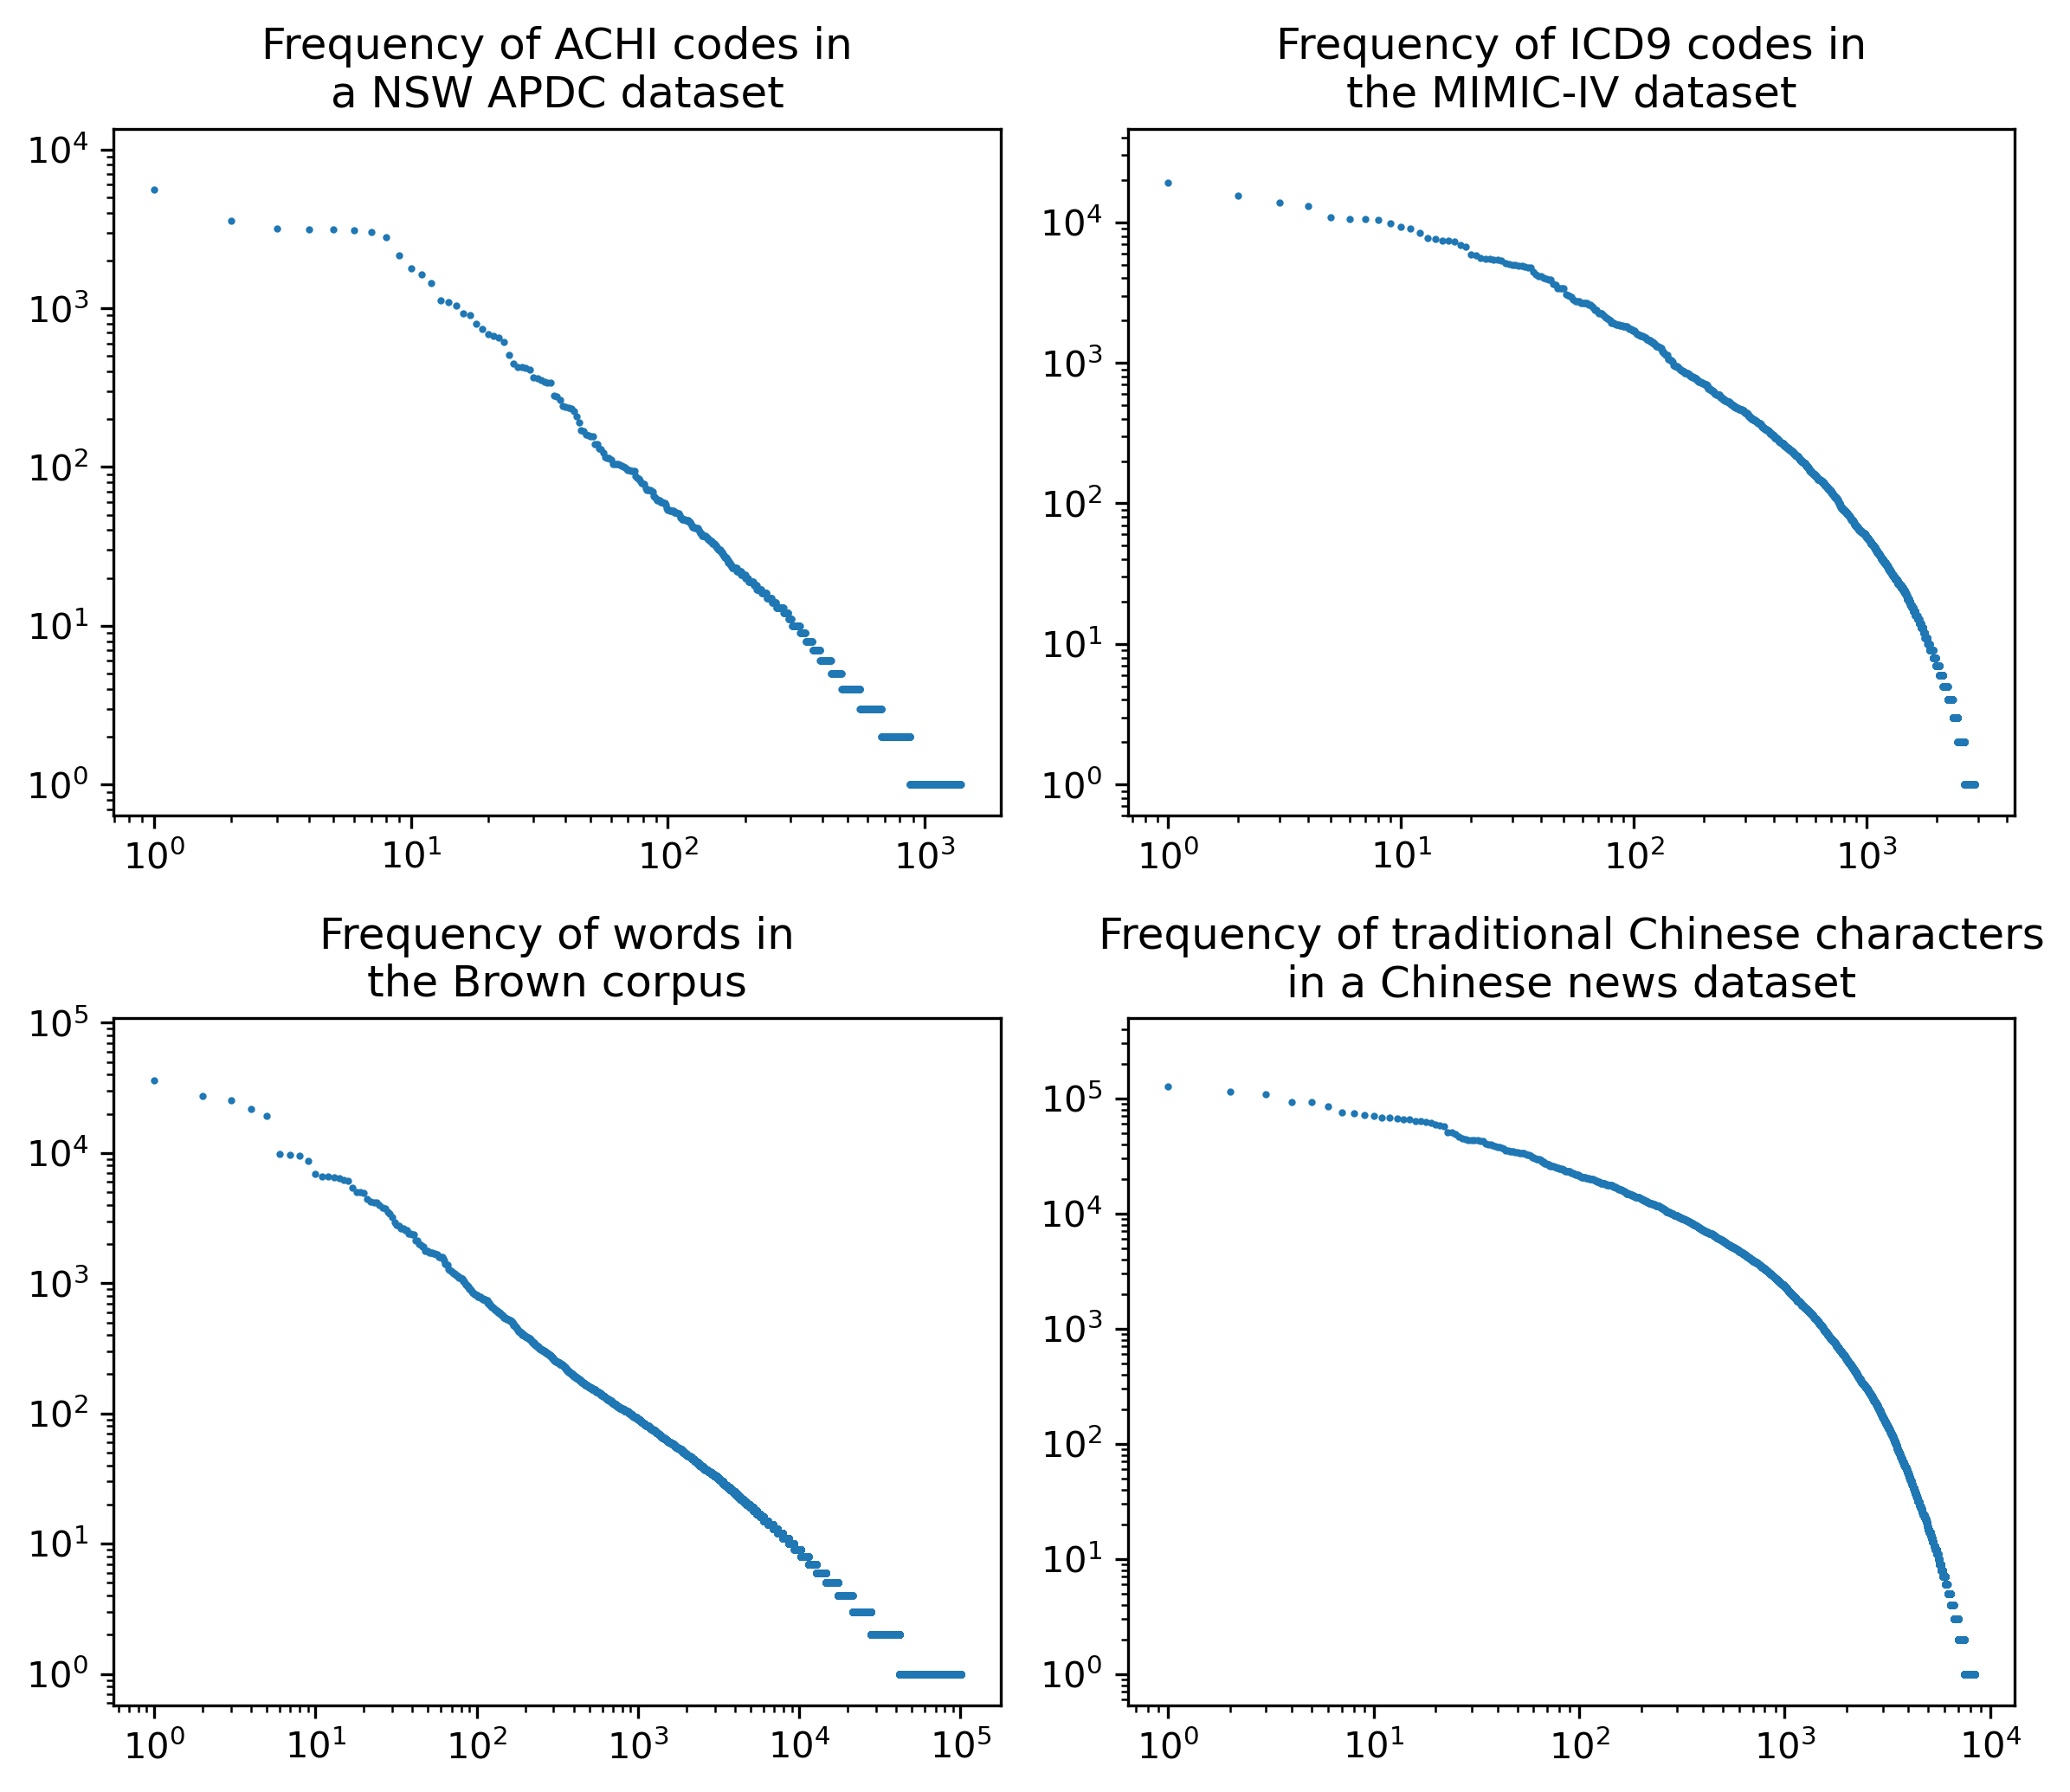

In [14]:
import pandas as pd
import numpy as np

mimic = pd.read_parquet("mimic_feature_set.parquet")["p_icd9_code"].value_counts().iloc[1:]
apdc = pd.Series(np.load("apdc_frequencies.npz")["f"])
brown = pd.Series(open("brown.txt", 'r').read().split()).value_counts()
zh = pd.Series(list("".join(map( str, pd.read_csv("news_collection.csv").desc.values)).strip().replace(" ", ""))).value_counts()
zh = zh[~zh.index.isin(list("1234567890zbcdefghijklmnopqrstuvqxyz，。,()."))]

# Plot a log-log rank-frequency plot for each sequence
from matplotlib import pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(8, 7), dpi=300)

# Make the point size small
plt.rcParams['lines.markersize'] = 1
axs[0, 0].loglog(range(len(apdc)), apdc.values, 'o')
axs[0, 0].set_title("Frequency of ACHI codes in\na NSW APDC dataset")

axs[0, 1].loglog(range(len(mimic)), mimic.values, 'o')
axs[0, 1].set_title("Frequency of ICD9 codes in\nthe MIMIC-IV dataset")

axs[1, 0].loglog(range(len(brown)), brown.values, 'o')
axs[1, 0].set_title("Frequency of words in\nthe Brown corpus")

axs[1, 1].loglog(range(len(zh)), zh.values, 'o')
axs[1, 1].set_title("Frequency of traditional Chinese characters\nin a Chinese news dataset")

plt.tight_layout()


In [47]:
import random

from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms import isomorphism
import pynauty

from catsyn._model_factory import ModelFactory
from weisfeiler_lehman_kernel import GK_WL

def networkx_to_pynauty(G):
    return {v: sorted(list(G.neighbors(v))) if not G.is_directed() else sorted(list(G.successors(v))) for v in G.nodes()}
    # return {v: sorted(list(G.neighbors(v))) if not G.is_directed() else sorted(list(G.successors(v))) for v in G.nodes()}

def canonicalise_graph(G):
    pynauty_graph = pynauty.Graph(number_of_vertices=G.number_of_nodes(), directed=G.is_directed(), adjacency_dict=networkx_to_pynauty(G))
    canon_lab = pynauty.canon_label(pynauty_graph)
    mapping = {v: canon_lab[v] for v in G.nodes()}
    inverse_mapping = {v: k for k, v in mapping.items()}

    G_canonical = nx.relabel_nodes(G, mapping)
    # G_canonical = G
    return G_canonical, mapping

def consistent_labelling(G1, G2):
    matcher = isomorphism.GraphMatcher(G1, G2)
    is_isomorphic = matcher.is_isomorphic()

    if is_isomorphic:
        mapping = matcher.mapping
        inverse_mapping = {v: k for k, v in mapping.items()}
        G2_relabeled = nx.relabel_nodes(G2, inverse_mapping)
        return G1, G2_relabeled
    else:
        raise ValueError("Graphs are not isomorphic")
    
def test_consistent_labelling(G1, G2):
    assert nx.is_isomorphic(G1, G2), "Not Isomorphic"
    for n1, n2 in zip(G1.nodes, G2.nodes):
        assert n1 == n2, f"Node values aren't the same: {n1=}, {n2=}"
        assert set(G1.successors(n1)) == set(G2.successors(n2)), f"Successors aren't the same: {set(G1.successors(n1))=}, {set(G1.successors(n2))=}"
        assert set(G1.predecessors(n1)) == set(G2.predecessors(n2)), f"Predecessors aren't the same:: {set(G1.predecessors(n1))=}, {set(G2.predecessors(n2))=}"

def print_graph_info(G):
    for v in G.nodes():
        print(f"Node {v} has degree: {G.degree(v)} and successors: {list(G.successors(v))}, predececssors: {list(G.predecessors(v))}")

G1 = ModelFactory.from_str('directed_extended_barabasi_albert_graph', {'n': 20, 'm': 2, 'p': 0.5, 'q': 0, "seed": 42})
G2 = G1.copy()
permutation = random.sample(list(G2.nodes), len(G2.nodes))
G2 = nx.relabel_nodes(G2, {node: permutation[i] for i, node in enumerate(G2.nodes)})

# Assuming G1 and G2 are already defined and isomorphic
G1_canonical, mapping = canonicalise_graph(G1)
G2_canonical = nx.relabel_nodes(G2, mapping)
G1_relabeled, G2_relabeled = consistent_labelling(G1, G2)

# from defrag import Defrag
# Defrag.plot_gtG_from_nxG(G1, size=(800,800))
# Defrag.plot_gtG_from_nxG(G2, size=(200,200))

nx.set_node_attributes(G1, "", "node_label")
nx.set_node_attributes(G2, "", "node_label")
nx.set_node_attributes(G1_canonical, "", "node_label")
nx.set_node_attributes(G2_canonical, "", "node_label")
nx.set_node_attributes(G1_relabeled, "", "node_label")
nx.set_node_attributes(G2_relabeled, "", "node_label")

# print_graph_info(G1)
# print()
# print_graph_info(G2)

print()
print("Are the consistently labeled graphs isomorphic?", nx.is_isomorphic(G1_relabeled, G2_relabeled))
print("Are they consistently labeled?", test_consistent_labelling(G1_relabeled, G2_relabeled))
print(GK_WL().compare(G1, G2, node_label=True, h=10))
print(GK_WL().compare(G1_canonical, G2_canonical, node_label=True, h=10))
print(GK_WL().compare(G1_relabeled, G2_relabeled, node_label=True, h=10))
print()



Are the consistently labeled graphs isomorphic? True
Are they consistently labeled? None
0.6677914009563591
0.6797966445116804
1.0



Node 0 has degree: 5 and successors: [1, 2, 3, 5, 6], predececssors: []
Node 1 has degree: 2 and successors: [], predececssors: [0, 3]
Node 2 has degree: 2 and successors: [3], predececssors: [0]
Node 3 has degree: 4 and successors: [1, 4], predececssors: [0, 2]
Node 4 has degree: 1 and successors: [], predececssors: [3]
Node 5 has degree: 1 and successors: [], predececssors: [0]
Node 6 has degree: 1 and successors: [], predececssors: [0]

Node 0 has degree: 5 and successors: [5, 6, 2, 3, 1], predececssors: []
Node 1 has degree: 2 and successors: [], predececssors: [0, 3]
Node 2 has degree: 2 and successors: [3], predececssors: [0]
Node 3 has degree: 4 and successors: [4, 1], predececssors: [0, 2]
Node 4 has degree: 1 and successors: [], predececssors: [3]
Node 5 has degree: 1 and successors: [], predececssors: [0]
Node 6 has degree: 1 and successors: [], predececssors: [0]


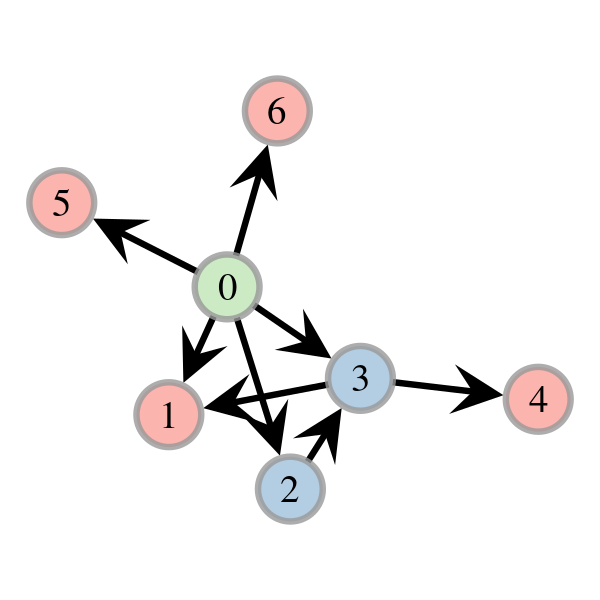

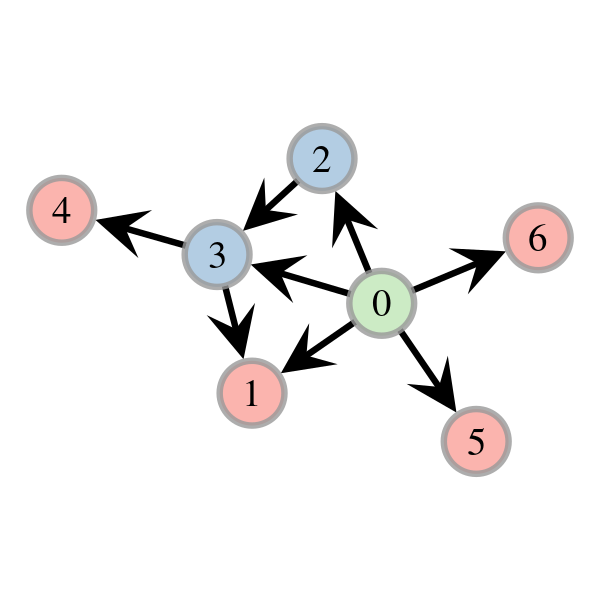

1.0

In [52]:
import numpy as np
from defrag import Defrag, Eval
from weisfeiler_lehman_kernel import GK_WL

def print_graph_info(G):
    for v in G.nodes():
        print(f"Node {v} has degree: {G.degree(v)} and successors: {list(G.successors(v))}, predececssors: {list(G.predecessors(v))}")

def consistent_labelling(G1, G2):
    matcher = isomorphism.GraphMatcher(G1, G2)
    is_isomorphic = matcher.is_isomorphic()

    if is_isomorphic:
        mapping = matcher.mapping
        inverse_mapping = {v: k for k, v in mapping.items()}
        G2_relabeled = nx.relabel_nodes(G2, inverse_mapping)
        # Reconstruct G2 with nodes in the same order as G1
        # Start by just creating an empty digraph with the same number of nodes as G1
        G2_reconstructed = nx.DiGraph()
        G2_reconstructed.add_nodes_from(G1.nodes())
        # Then add edges from G2_relabeled to G2_recunstructed
        for v in G2.nodes():
            for u in G2.successors(v):
                G2_reconstructed.add_edge(inverse_mapping[v], inverse_mapping[u])
        return G1, G2_reconstructed
    else:
        raise ValueError("Graphs are not isomorphic")


syn_G_am = np.load("/workspaces/defrag/experiments/synthetic_data_experiment_big_1000_bins/experiment_b9f90c3/syn_G_adjacency_matrix.npz", allow_pickle=True)["am"]
inf_G_am = np.load("/workspaces/defrag/experiments/synthetic_data_experiment_big_1000_bins/experiment_b9f90c3/defrag_data.npz", allow_pickle=True)["ham"]

# Convert the adjacency matrices to directed networkx graphs
import networkx as nx
syn_G = nx.from_numpy_matrix(syn_G_am.T, create_using=nx.DiGraph)
inf_G = nx.from_numpy_matrix(inf_G_am, create_using=nx.DiGraph)

# print_graph_info(syn_G)
# print()
# print_graph_info(inf_G)
# print()
syn_G, inf_G = consistent_labelling(syn_G, inf_G)

print_graph_info(syn_G)
print()
print_graph_info(inf_G)

Eval.check_consistent_labelling(syn_G, inf_G)
test_consistent_labelling(syn_G, inf_G)

Defrag.plot_gtG_from_nxG(syn_G, size=(300,300))
Defrag.plot_gtG_from_nxG(inf_G, size=(300,300))

nx.set_node_attributes(syn_G, "", "node_label")
nx.set_node_attributes(inf_G, "", "node_label")
float(GK_WL().compare(syn_G, inf_G, h=1, node_label=True))


In [4]:
from tqdm import tqdm

eventset = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
# eventset = list("ABCD")
SEQLEN = 6
WINDOW_LEN = 5
PADDING = (WINDOW_LEN - 1) // 2

import itertools
perm_variant = [p for p in tqdm(itertools.product(eventset, repeat=SEQLEN))]
# print(perm_variant)
# Add padding of "_" to the beginning and end of each sequence in perm_variant
perm_variant = [f"{'_'*PADDING}{''.join(p)}{'_'*PADDING}" for p in tqdm(perm_variant)]

neighbourhoods = dict()
for element in eventset:
    neighbourhoods[element] = set()

for sequence in tqdm(perm_variant):
    seq_neighbourhoods = [
        (sequence[cursor:cursor+WINDOW_LEN], sequence[cursor+PADDING])
        for cursor in range(len(sequence)-WINDOW_LEN+1)
    ]
    for neighbourhood, anchor in seq_neighbourhoods:
        neighbourhoods[anchor].add(neighbourhood)

# print([neighbourhoods.__len__() for neighbourhoods in neighbourhoods.values()])
print(sum(map(len, neighbourhoods.values())))


640
